In [1]:
import sys
from print_versions import print_versions

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt

pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = [15.00, 10]
plt.rcParams["figure.autolayout"] = True

test_size = 0.2

%matplotlib inline

print(sys.version)
print_versions(globals())

3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
pandas==2.2.3
matplotlib==3.9.3
numpy==1.26.4
sklearn==1.5.2
catboost==1.2.7
scikitplot==0.3.7


In [2]:
rand_seed = 42

file = 'gold_patterns_with_metrics_only_consensus.csv'
capis = pd.read_csv(file, sep=',', usecols=lambda x: x not in ['capillaroscopy_id']).replace('CONNECTIVE_TISSUE_DISEASE', 'NON_SPECIFIC')

capis.gold.unique()

print('Total capis:', len(capis))

capis = capis[capis['image_count'] >= 8]
capis = capis.drop(capis.filter(regex='^.+_quantity$'), axis = 'columns')
capis = capis.drop(capis.filter(regex='^.+_area$'), axis = 'columns')

capis = capis.drop(['image_count', 'eval_mm'], axis = 'columns')

print('Capis with at least 2/3 consensus and at least 8 images: ', len(capis))

capis.fillna(-1, inplace=True)

Total capis: 1518
Capis with at least 2/3 consensus and at least 8 images:  1490


In [3]:
train_df, test_df = train_test_split(capis, random_state=rand_seed, test_size=test_size)

In [4]:
train_capis = train_df.copy().drop(['total_consensus'], axis = 'columns')
test_capis = test_df.copy().drop(['total_consensus'], axis = 'columns')
test_capis_total_consensus = test_df[test_df['total_consensus']].copy().drop(['total_consensus'], axis = 'columns')

print(train_capis.columns)

print(len(train_capis))
print(len(test_capis))
print(len(test_capis_total_consensus))

Index(['gold', 'all_density', 'all_apical_diameter_avg', 'all_limb_width_avg',
       'all_area_density', 'enlarged_density', 'enlarged_percent',
       'enlarged_apical_diameter_avg', 'enlarged_limb_width_avg',
       'enlarged_area_density', 'giant_density', 'giant_percent',
       'giant_apical_diameter_avg', 'giant_limb_width_avg',
       'giant_area_density', 'tortuosity_density', 'tortuosity_percent',
       'tortuosity_apical_diameter_avg', 'tortuosity_limb_width_avg',
       'tortuosity_area_density', 'abnormal_density', 'abnormal_percent',
       'abnormal_area_density', 'hemorrhage_density',
       'hemorrhage_area_density'],
      dtype='object')
1192
298
100


# Train Capi-Detect SSc vs Non-SSC model

In [5]:
train_capis_ssc_vs_non_ssc = train_capis.copy().replace('NON_SPECIFIC', 'NORMAL').replace('EARLY', 'SSC').replace('ACTIVE', 'SSC').replace('LATE', 'SSC')
test_capis_ssc_vs_non_ssc = test_capis.copy().replace('NON_SPECIFIC', 'NORMAL').replace('EARLY', 'SSC').replace('ACTIVE', 'SSC').replace('LATE', 'SSC')
test_capis_ssc_vs_non_ssc_total_consensus = test_capis_total_consensus.copy().replace('NON_SPECIFIC', 'NORMAL').replace('EARLY', 'SSC').replace('ACTIVE', 'SSC').replace('LATE', 'SSC')

X_train = train_capis_ssc_vs_non_ssc.drop('gold', axis=1)
y_train = train_capis_ssc_vs_non_ssc.gold

X_test = test_capis_ssc_vs_non_ssc.drop('gold', axis=1)
y_test = test_capis_ssc_vs_non_ssc.gold

X_test_total_consensus = test_capis_ssc_vs_non_ssc_total_consensus.drop('gold', axis=1)
y_test_total_consensus = test_capis_ssc_vs_non_ssc_total_consensus.gold

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print(class_weights)

print('Train examples')
print(len(y_train[y_train == 'NORMAL']))
print(len(y_train[y_train == 'SSC']))

print('Test examples')
print(len(y_test[y_test == 'NORMAL']))
print(len(y_test[y_test == 'SSC']))

print('Test examples (total consensus only)')
print(len(y_test_total_consensus[y_test == 'NORMAL']))
print(len(y_test_total_consensus[y_test == 'SSC']))

{'NORMAL': 0.7563451776649747, 'SSC': 1.4752475247524752}
Train examples
788
404
Test examples
197
101
Test examples (total consensus only)
60
40


In [6]:
model = CatBoostClassifier(
    depth=4,
    random_state=rand_seed,
    learning_rate=0.0002,
    iterations=40000,
    logging_level='Silent'
)

train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

model.fit(
    train_pool,
    eval_set=validate_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [7]:
y_pred = model.predict(X_test)
print("Capi-Detect SSc vs Non-SSc model accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Capi-Detect SSc vs Non-SSc model accuracy: 0.912751677852349
              precision    recall  f1-score   support

      NORMAL       0.92      0.95      0.94       197
         SSC       0.89      0.84      0.87       101

    accuracy                           0.91       298
   macro avg       0.91      0.90      0.90       298
weighted avg       0.91      0.91      0.91       298



In [8]:
y_pred_total_consensus = model.predict(X_test_total_consensus)
print("Capi-Detect SSc vs Non-SSc accuracy (total consensus only):", accuracy_score(y_test_total_consensus, y_pred_total_consensus))
print(classification_report(y_test_total_consensus, y_pred_total_consensus))

Capi-Detect SSc vs Non-SSc accuracy (total consensus only): 0.91
              precision    recall  f1-score   support

      NORMAL       0.95      0.90      0.92        60
         SSC       0.86      0.93      0.89        40

    accuracy                           0.91       100
   macro avg       0.90      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [9]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
feature_importances_map = {}
top_features = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    feature_importances_map[name] = score
    top_features.append(name)
    print('{}: {}'.format(name, score))

giant_percent: 13.819793914952069
giant_area_density: 10.486596180220108
enlarged_apical_diameter_avg: 8.050880417813142
giant_density: 7.241157452851418
hemorrhage_density: 6.611146539964924
hemorrhage_area_density: 5.420790070946145
all_density: 5.394421439875167
enlarged_limb_width_avg: 3.8896515484631116
abnormal_percent: 3.4647384692619907
all_area_density: 3.4412331384594004
abnormal_area_density: 3.1412271508682466
tortuosity_density: 2.998674911824277
all_limb_width_avg: 2.7293476202912164
tortuosity_apical_diameter_avg: 2.7238627385575542
enlarged_percent: 2.5467507818480772
all_apical_diameter_avg: 2.3620206866155353
enlarged_area_density: 2.3041371124368384
giant_apical_diameter_avg: 2.080269205128428
tortuosity_limb_width_avg: 2.0749923266349026
tortuosity_area_density: 1.9919190606589494
enlarged_density: 1.9917180022411218
tortuosity_percent: 1.8792530657856188
giant_limb_width_avg: 1.7655380878222025
abnormal_density: 1.5898800764795455


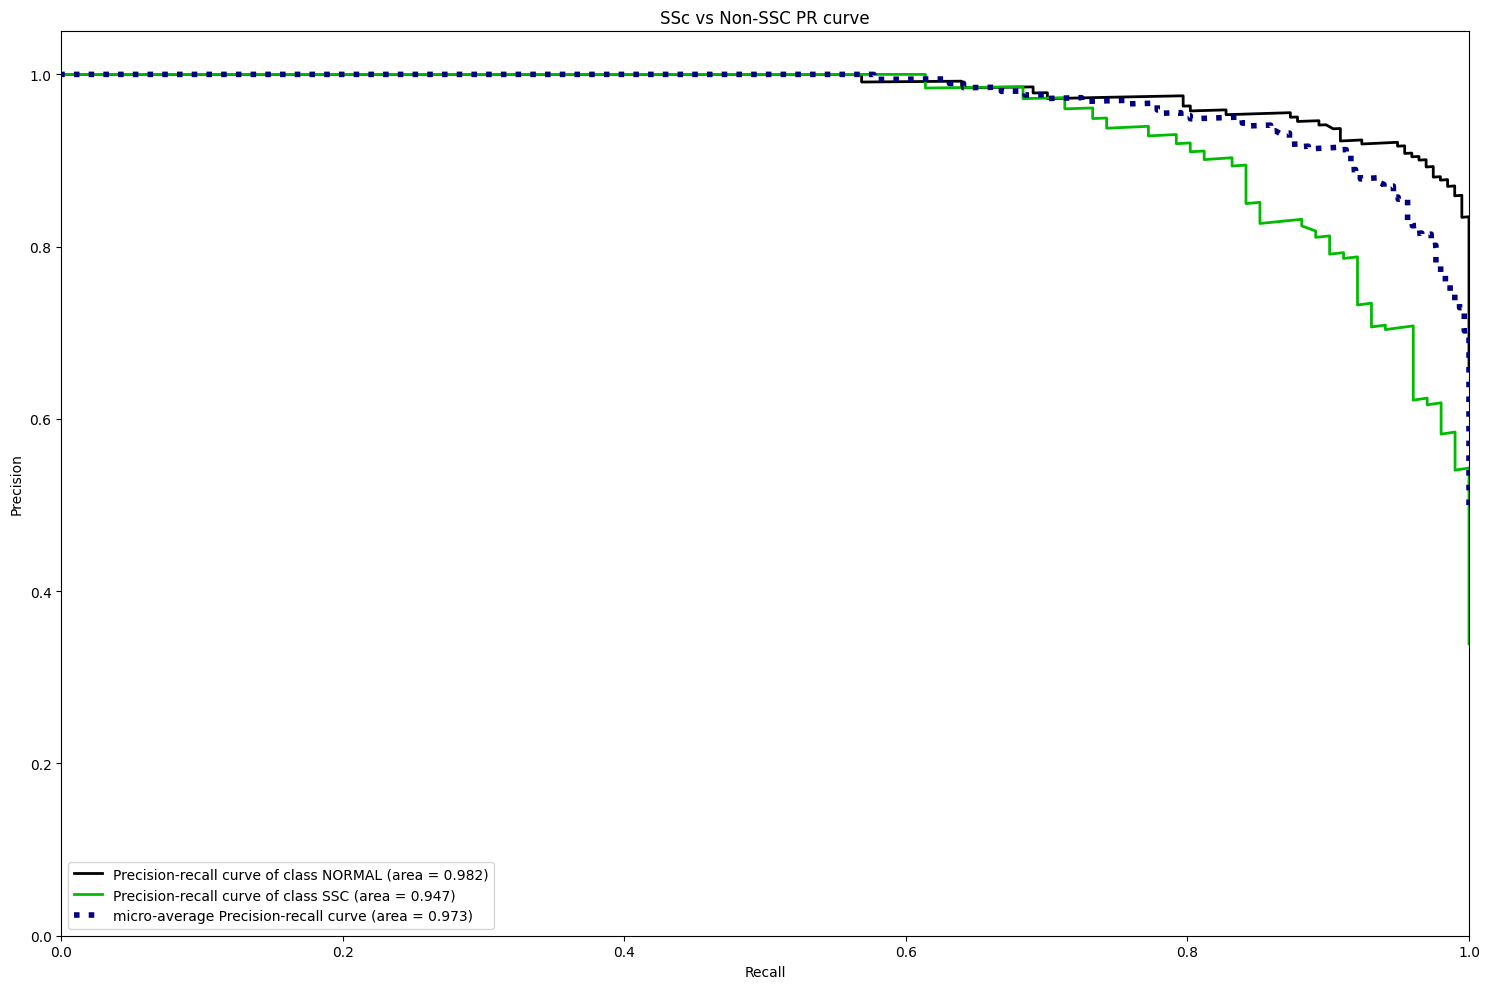

In [10]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, cmap='nipy_spectral')
plt.title('SSc vs Non-SSC PR curve')
plt.savefig('pr_ssc_vs_non_ssc.svg')
plt.savefig('pr_ssc_vs_non_ssc.png', dpi=300)
plt.show()

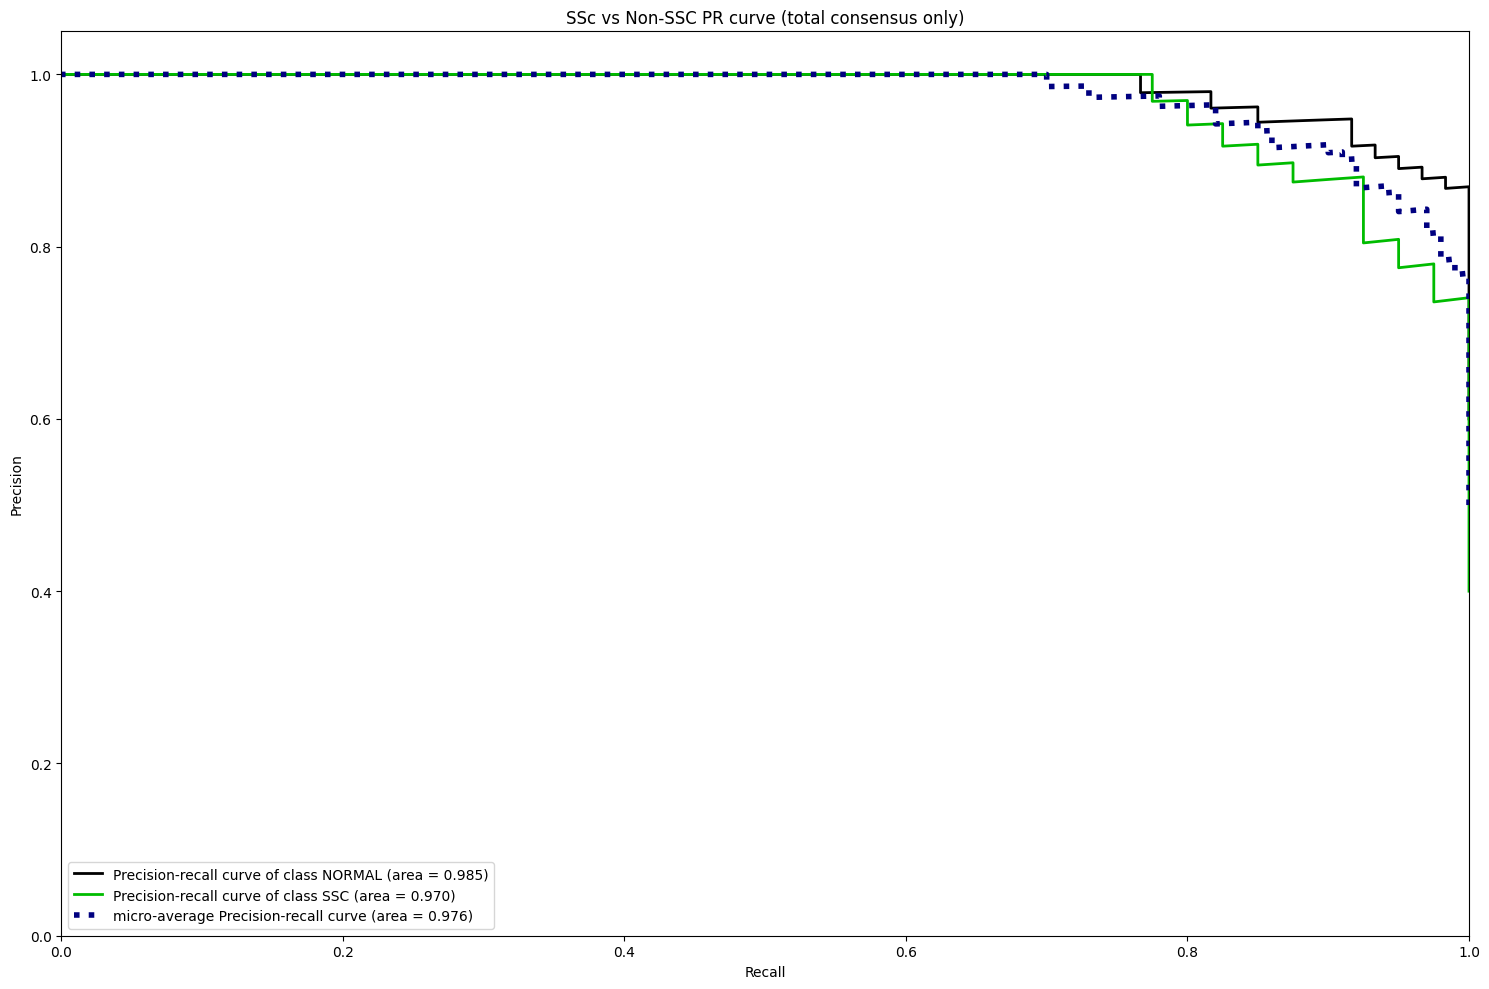

In [11]:
y_probas_total_consensus = model.predict_proba(X_test_total_consensus)
skplt.metrics.plot_precision_recall(y_test_total_consensus, y_probas_total_consensus, cmap='nipy_spectral')
plt.title('SSc vs Non-SSC PR curve (total consensus only)')
plt.savefig('pr_ssc_vs_non_ssc_total_consensus.svg')
plt.savefig('pr_ssc_vs_non_ssc_total_consensus.png', dpi=300)
plt.show()

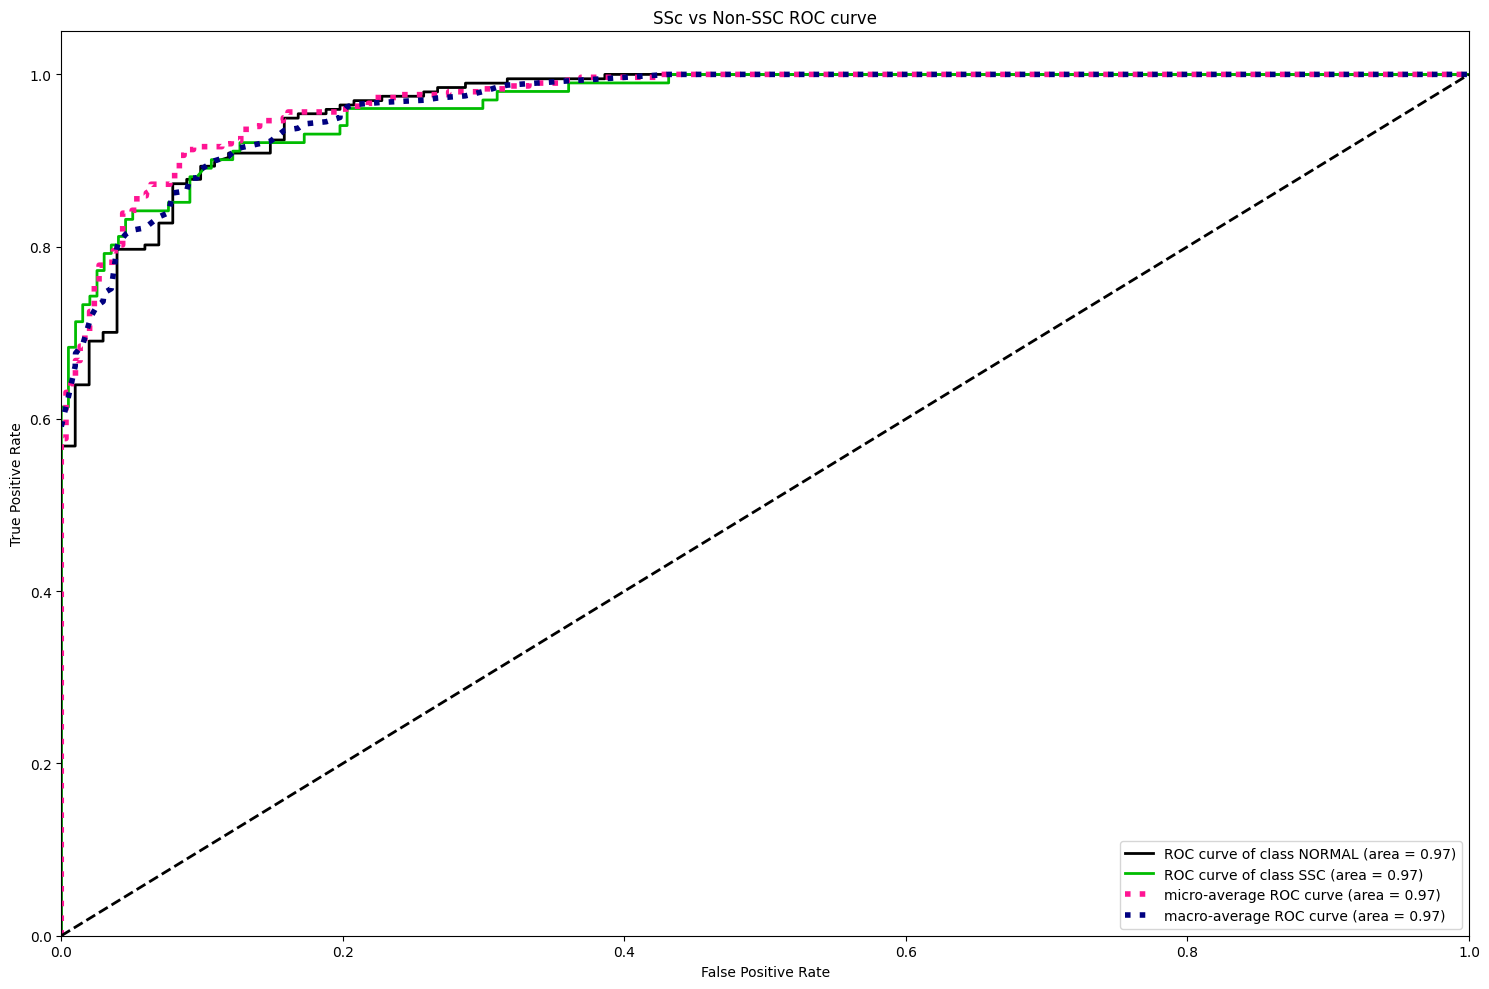

In [12]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, cmap='nipy_spectral')
plt.title('SSc vs Non-SSC ROC curve')
plt.savefig('roc_ssc_vs_non_ssc.svg')
plt.savefig('roc_ssc_vs_non_ssc.png', dpi=300)
plt.show()

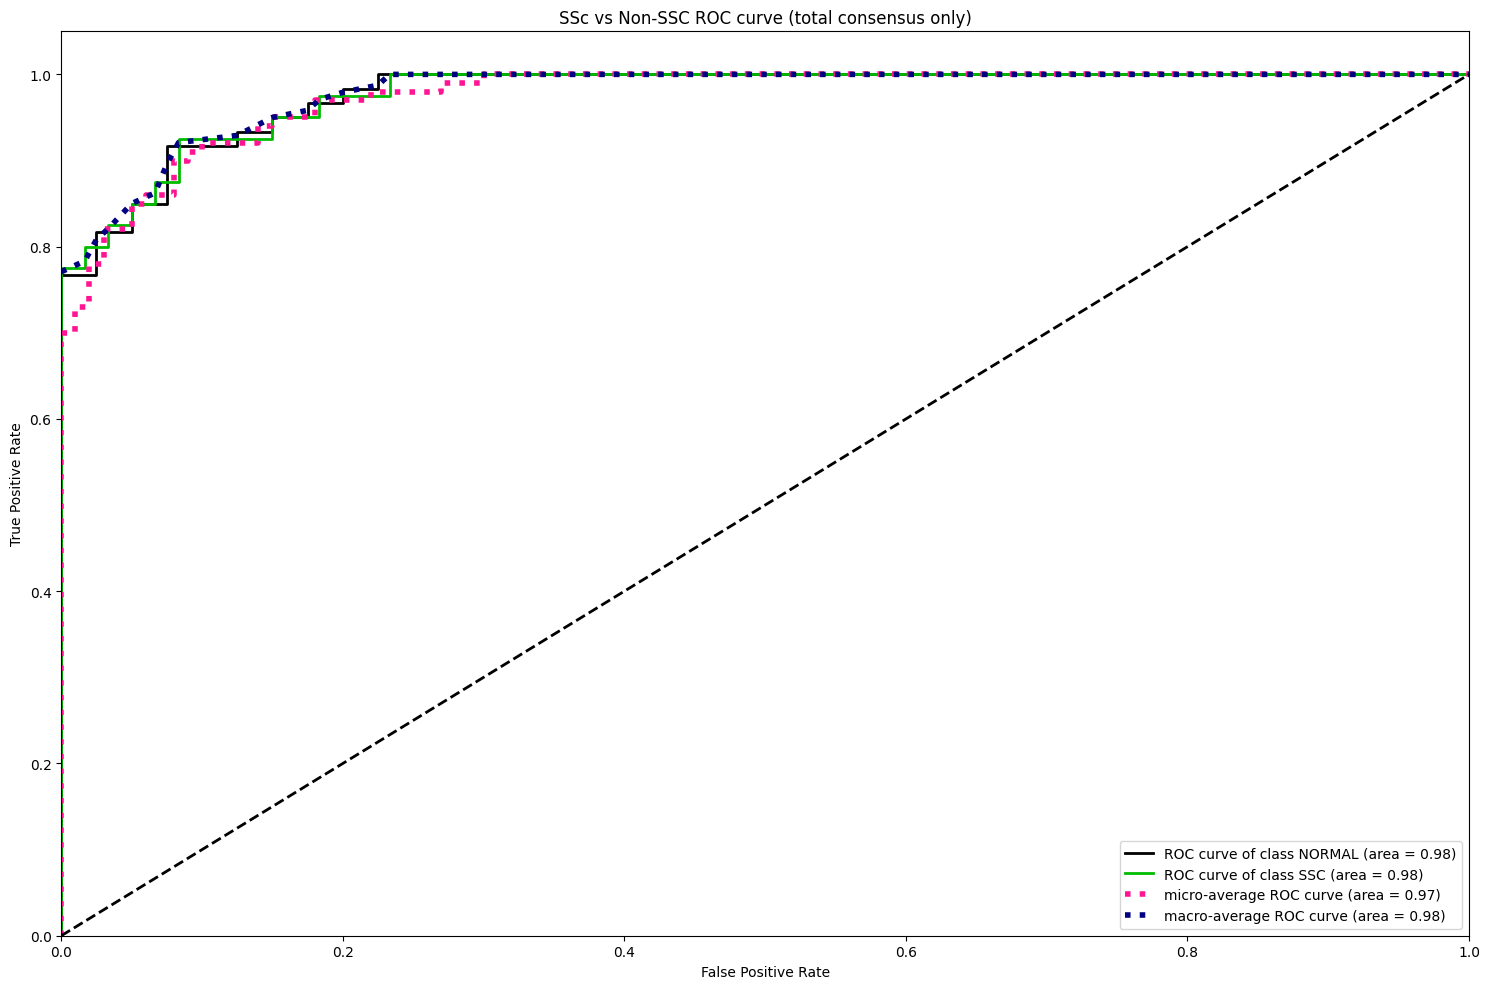

In [13]:
y_probas_total_consensus = model.predict_proba(X_test_total_consensus)
skplt.metrics.plot_roc(y_test_total_consensus, y_probas_total_consensus, cmap='nipy_spectral')
plt.title('SSc vs Non-SSC ROC curve (total consensus only)')
plt.savefig('roc_ssc_vs_non_ssc_total_consensus.svg')
plt.savefig('roc_ssc_vs_non_ssc_total_consensus.png', dpi=300)
plt.show()

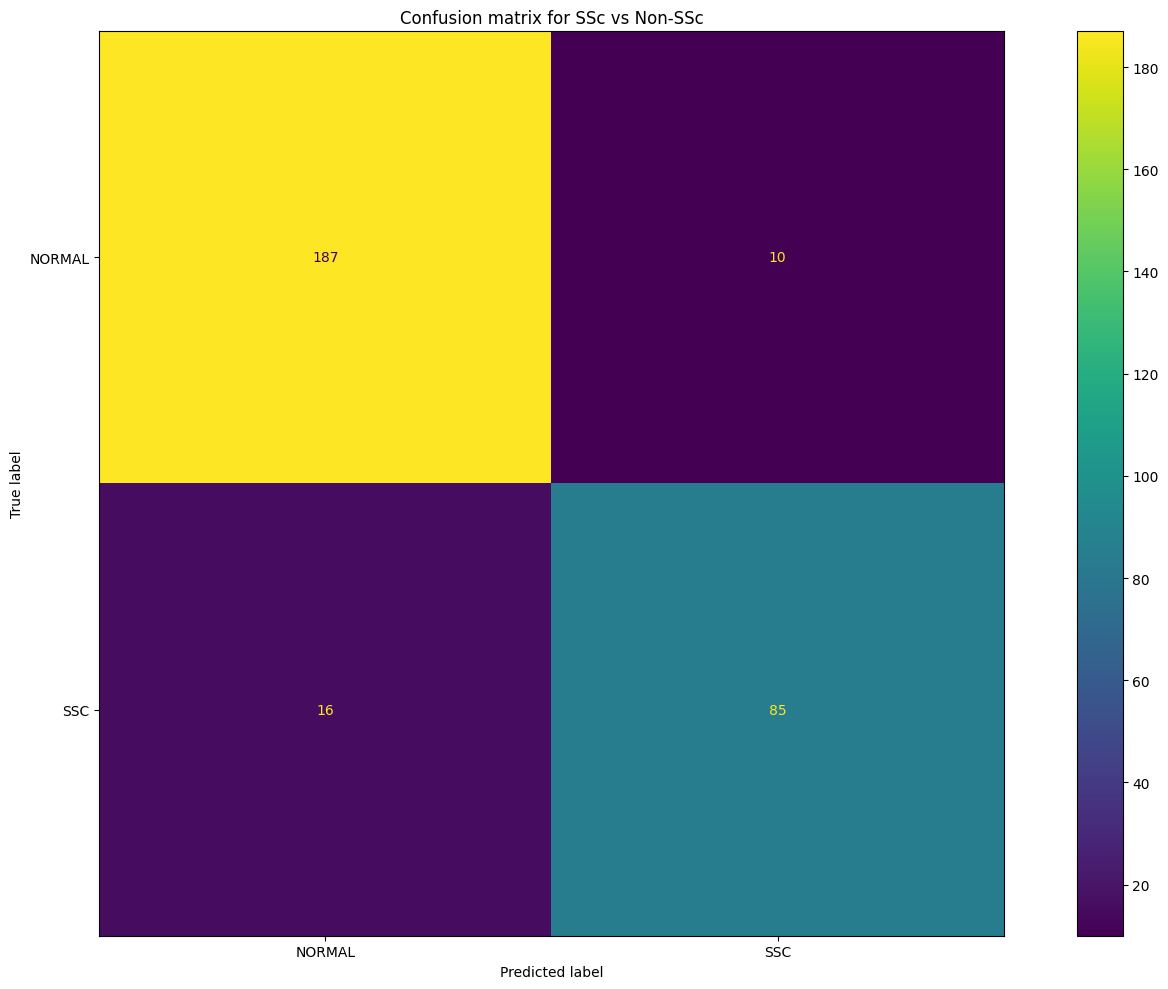

In [14]:
predicted = model.predict(X_test)
cm = confusion_matrix(y_test, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.title('Confusion matrix for SSc vs Non-SSc')
plt.show()

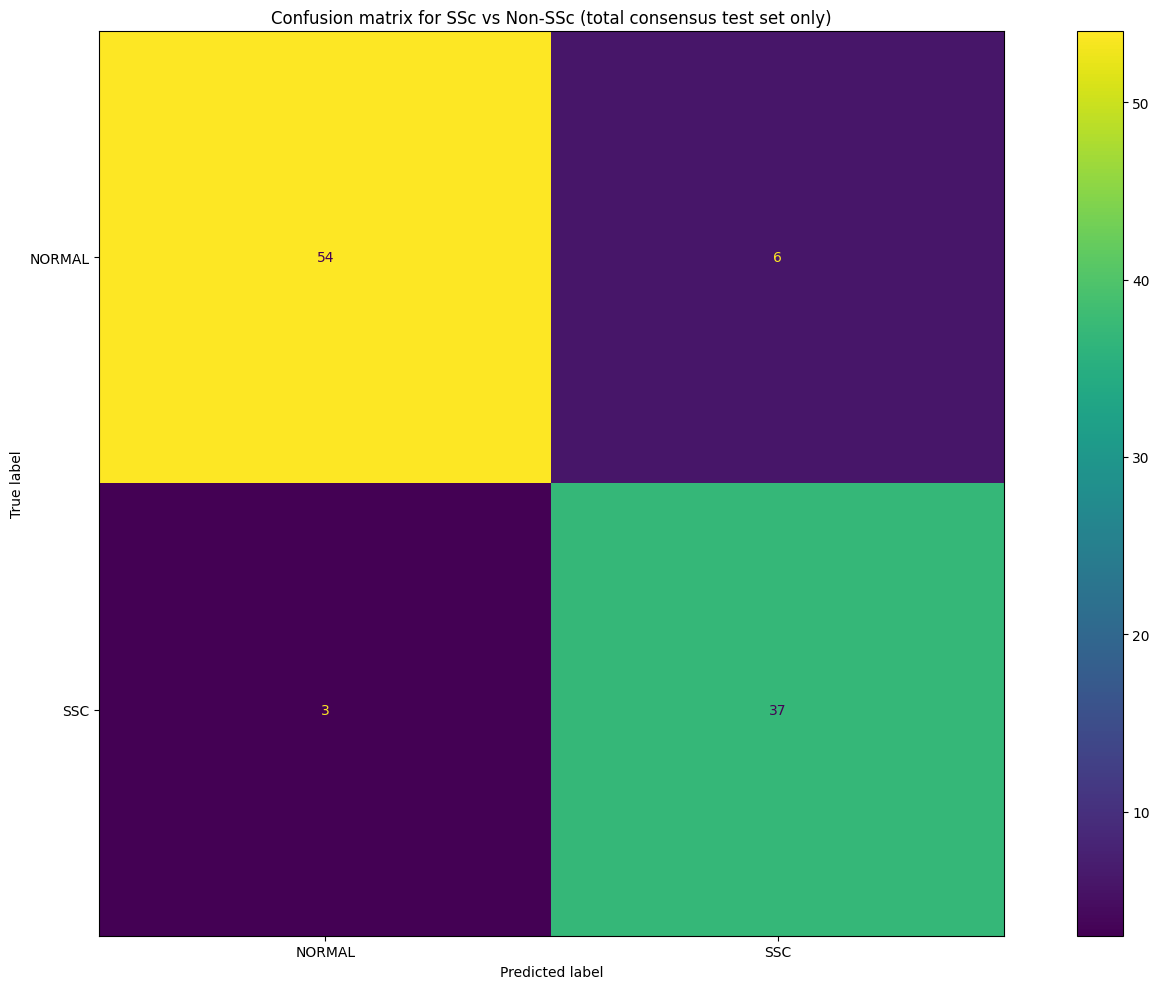

In [15]:
predicted_total_consensus = model.predict(X_test_total_consensus)
cm_total_consensus = confusion_matrix(y_test_total_consensus, predicted_total_consensus)

disp_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_total_consensus, display_labels=classes)
disp_total_consensus.plot()
plt.title('Confusion matrix for SSc vs Non-SSc (total consensus test set only)')
plt.show()

In [16]:
train_capis_ssc = train_capis.copy()
train_capis_ssc = train_capis[train_capis['gold'].isin(['EARLY', 'ACTIVE', 'LATE'])]

test_capis_ssc = test_capis.copy()
test_capis_ssc = test_capis_ssc[test_capis_ssc['gold'].isin(['EARLY', 'ACTIVE', 'LATE'])]

test_capis_ssc_total_consensus = test_capis_total_consensus.copy()
test_capis_ssc_total_consensus = test_capis_total_consensus[test_capis_total_consensus['gold'].isin(['EARLY', 'ACTIVE', 'LATE'])]

print('Total capis for SSC:', len(train_capis_ssc))

train_capis_ssc.gold.value_counts()

Total capis for SSC: 404


gold
EARLY     211
ACTIVE    137
LATE       56
Name: count, dtype: int64

# Train Capi-Detect SSc type model

In [17]:
X_train_ssc = train_capis_ssc.drop('gold', axis=1)
y_train_ssc = train_capis_ssc.gold

X_test_ssc = test_capis_ssc.drop('gold', axis=1)
y_test_ssc = test_capis_ssc.gold

X_test_ssc_total_consensus = test_capis_ssc_total_consensus.drop('gold', axis=1)
y_test_ssc_total_consensus = test_capis_ssc_total_consensus.gold

classes_ssc = np.unique(y_train_ssc)
weights_ssc = compute_class_weight(class_weight='balanced', classes=classes_ssc, y=y_train_ssc)
class_weights_ssc = dict(zip(classes_ssc, weights_ssc))

print(class_weights_ssc)

print('Train examples')
print(len(y_train_ssc[y_train_ssc == 'EARLY']))
print(len(y_train_ssc[y_train_ssc == 'ACTIVE']))
print(len(y_train_ssc[y_train_ssc == 'LATE']))

print('Test examples')
print(len(y_test_ssc[y_test_ssc == 'EARLY']))
print(len(y_test_ssc[y_test_ssc == 'ACTIVE']))
print(len(y_test_ssc[y_test_ssc == 'LATE']))

print('Test examples (total consensus only)')
print(len(y_test_ssc_total_consensus[y_test_ssc_total_consensus == 'EARLY']))
print(len(y_test_ssc_total_consensus[y_test_ssc_total_consensus == 'ACTIVE']))
print(len(y_test_ssc_total_consensus[y_test_ssc_total_consensus == 'LATE']))

{'ACTIVE': 0.9829683698296837, 'EARLY': 0.6382306477093207, 'LATE': 2.4047619047619047}
Train examples
211
137
56
Test examples
45
39
17
Test examples (total consensus only)
14
18
8


In [18]:
model_ssc = CatBoostClassifier(
    random_state=rand_seed,
    depth=4,
    learning_rate=0.0003,
    iterations=60000,
    logging_level='Silent'
)

train_pool_ssc = Pool(X_train_ssc, y_train_ssc)
validate_pool_ssc = Pool(X_test_ssc, y_test_ssc)

model_ssc.fit(
    train_pool_ssc,
    eval_set=validate_pool_ssc,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
y_pred_ssc = model_ssc.predict(X_test_ssc)
print("Capi-Detect SSC model accuracy:", accuracy_score(y_test_ssc, y_pred_ssc))
print(classification_report(y_test_ssc, y_pred_ssc))

Capi-Detect SSC model accuracy: 0.8118811881188119
              precision    recall  f1-score   support

      ACTIVE       0.76      0.74      0.75        39
       EARLY       0.87      0.91      0.89        45
        LATE       0.75      0.71      0.73        17

    accuracy                           0.81       101
   macro avg       0.80      0.79      0.79       101
weighted avg       0.81      0.81      0.81       101



In [20]:
y_pred_ssc_total_consensus = model_ssc.predict(X_test_ssc_total_consensus)
print("Capi-Detect SSc SSC model accuracy (total consensus only):", accuracy_score(y_test_ssc_total_consensus, y_pred_ssc_total_consensus))
print(classification_report(y_test_ssc_total_consensus, y_pred_ssc_total_consensus))

Capi-Detect SSc SSC model accuracy (total consensus only): 0.925
              precision    recall  f1-score   support

      ACTIVE       0.89      0.94      0.92        18
       EARLY       0.92      0.86      0.89        14
        LATE       1.00      1.00      1.00         8

    accuracy                           0.93        40
   macro avg       0.94      0.93      0.94        40
weighted avg       0.93      0.93      0.92        40



In [21]:
feature_importances_ssc = model_ssc.get_feature_importance(train_pool_ssc)
feature_names_ssc = X_train_ssc.columns
feature_importances_map_ssc = {}
top_features_ssc = []
for score, name in sorted(zip(feature_importances_ssc, feature_names_ssc), reverse=True):
    feature_importances_map_ssc[name] = score
    top_features_ssc.append(name)
    print('{}: {}'.format(name, score))

all_density: 15.265963352726738
giant_area_density: 11.935188508313068
enlarged_density: 9.489941439832222
abnormal_area_density: 8.219001554380664
abnormal_percent: 7.5150441062467985
giant_percent: 6.4967535484474945
giant_density: 5.607192402151134
enlarged_percent: 4.406223494111316
hemorrhage_area_density: 3.788256106338296
abnormal_density: 2.97941910361648
tortuosity_apical_diameter_avg: 2.706467187141037
hemorrhage_density: 2.6973802756029652
giant_limb_width_avg: 2.6306273015270176
enlarged_limb_width_avg: 2.082692914291539
tortuosity_area_density: 1.9427290120977265
giant_apical_diameter_avg: 1.9392944111237622
tortuosity_limb_width_avg: 1.7039154297554857
all_apical_diameter_avg: 1.4688757524776277
all_area_density: 1.4430039052021633
tortuosity_percent: 1.376084142648866
enlarged_area_density: 1.2048812026779234
all_limb_width_avg: 1.1265907465192315
enlarged_apical_diameter_avg: 1.1019679764340313
tortuosity_density: 0.8725061263363787


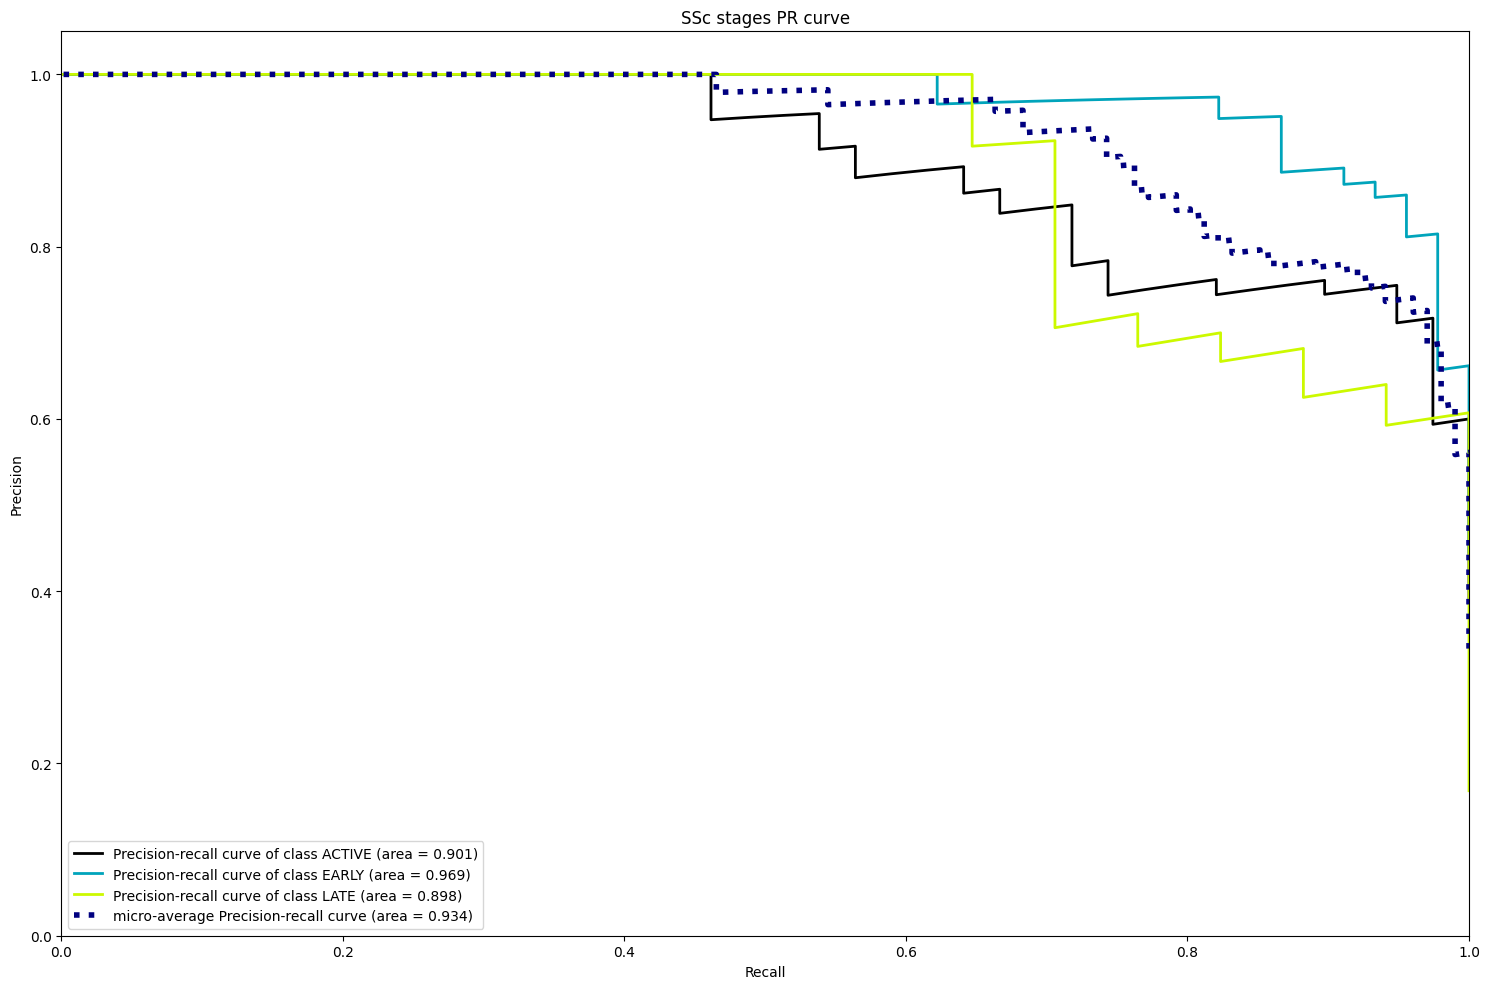

In [22]:
y_probas_ssc = model_ssc.predict_proba(X_test_ssc)
skplt.metrics.plot_precision_recall(y_test_ssc, y_probas_ssc, cmap='nipy_spectral')
plt.title('SSc stages PR curve')
plt.savefig('pr_ssc_stages.svg')
plt.savefig('pr_ssc_stages.png', dpi=300)
plt.show()

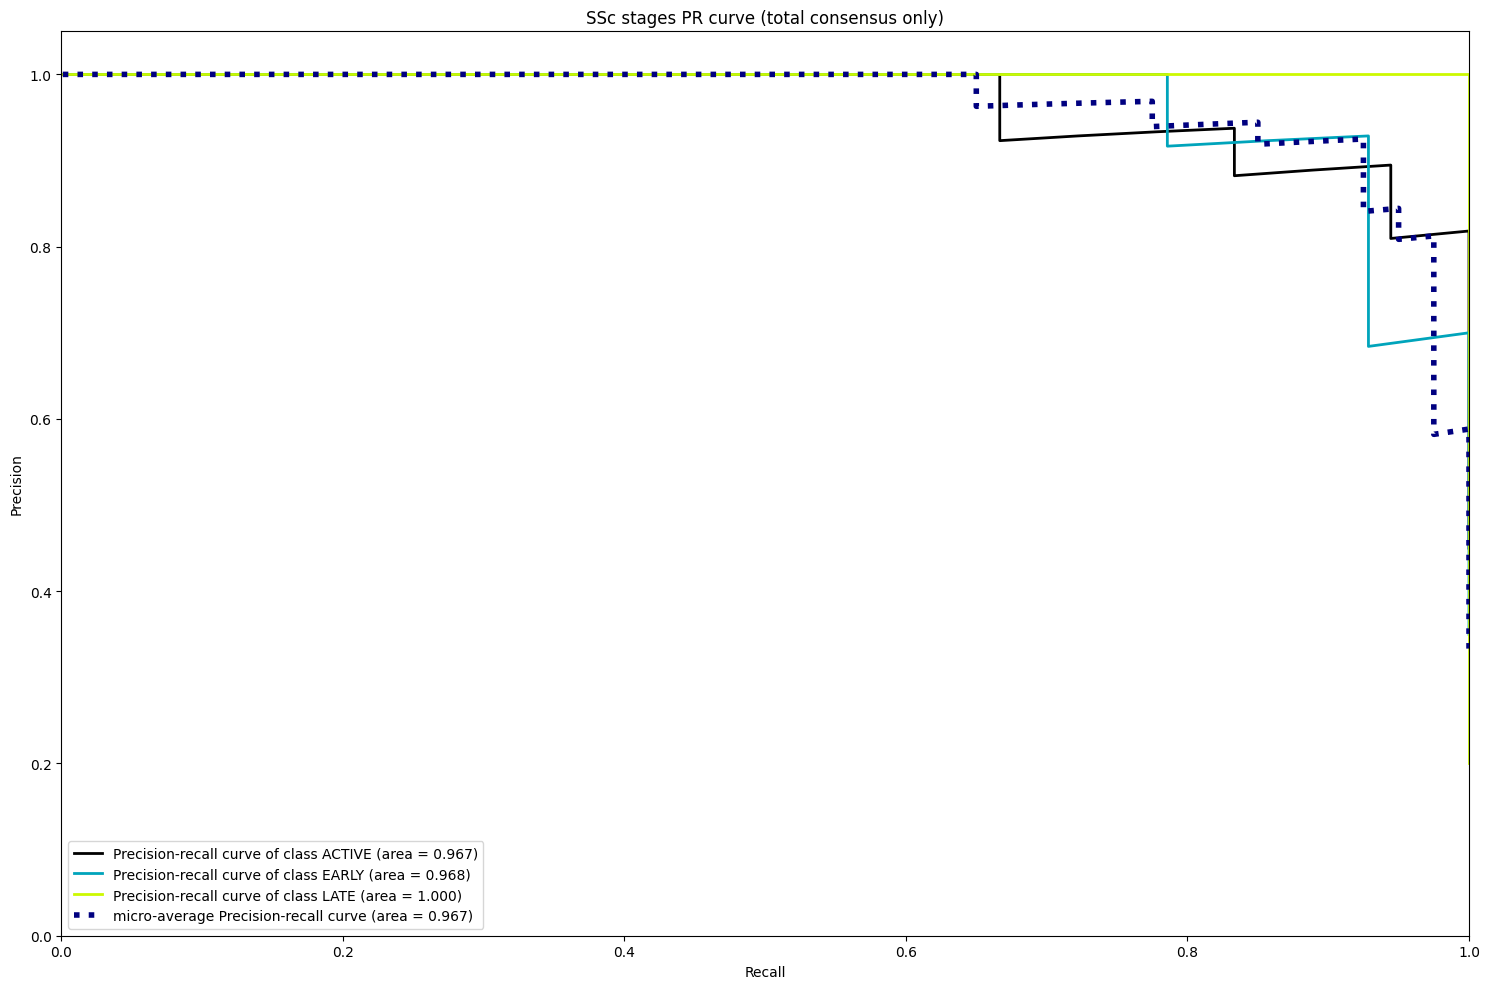

In [23]:
y_probas_ssc_total_consensus = model_ssc.predict_proba(X_test_ssc_total_consensus)
skplt.metrics.plot_precision_recall(y_test_ssc_total_consensus, y_probas_ssc_total_consensus, cmap='nipy_spectral')
plt.title('SSc stages PR curve (total consensus only)')
plt.savefig('pr_ssc_stages_total_consensus.svg')
plt.savefig('pr_ssc_stages_total_consensus.png', dpi=300)
plt.show()

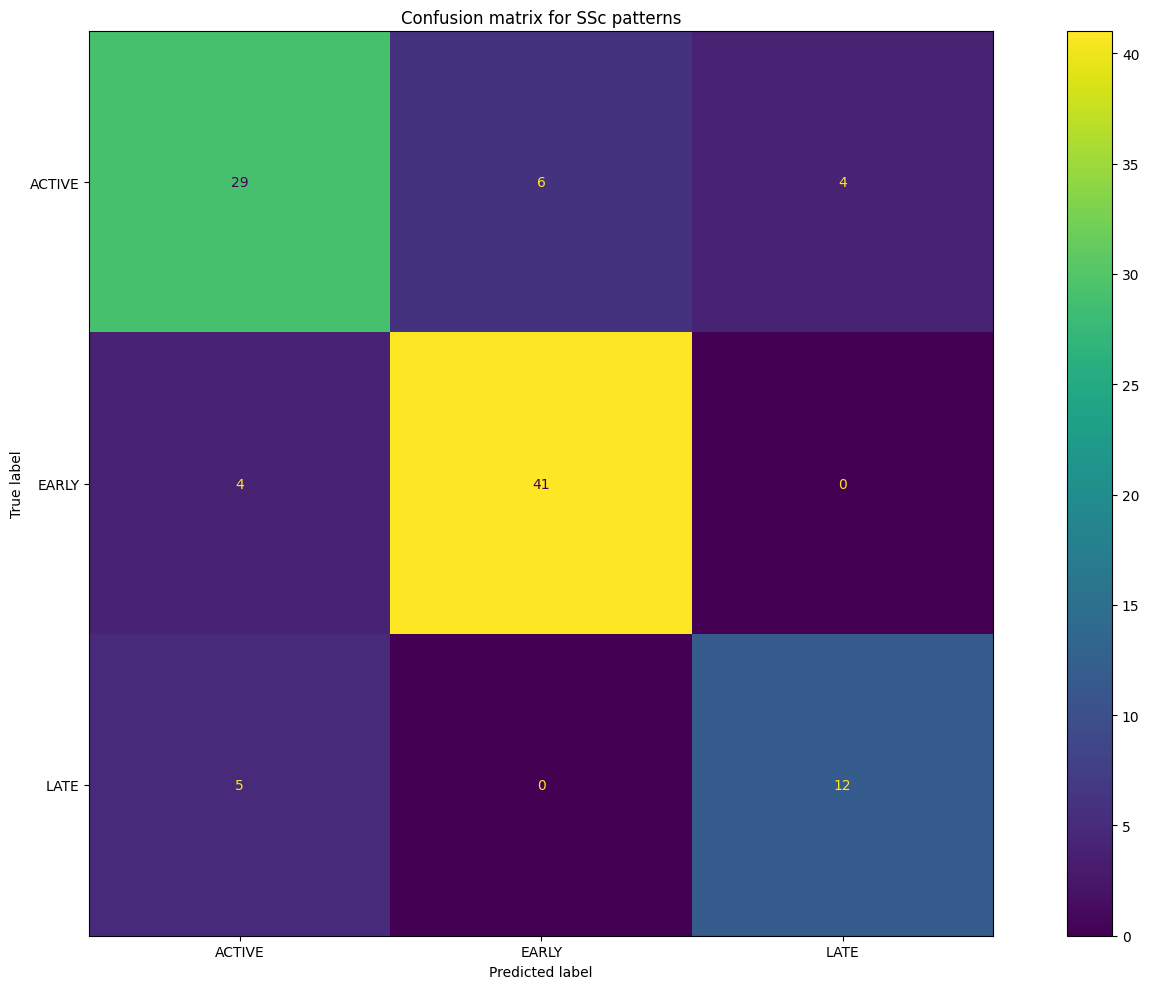

In [24]:
predicted_ssc = model_ssc.predict(X_test_ssc)
cm_ssc = confusion_matrix(y_test_ssc, predicted_ssc)

disp_ssc = ConfusionMatrixDisplay(confusion_matrix=cm_ssc, display_labels=classes_ssc)
disp_ssc.plot()
plt.title('Confusion matrix for SSc patterns')
plt.show()

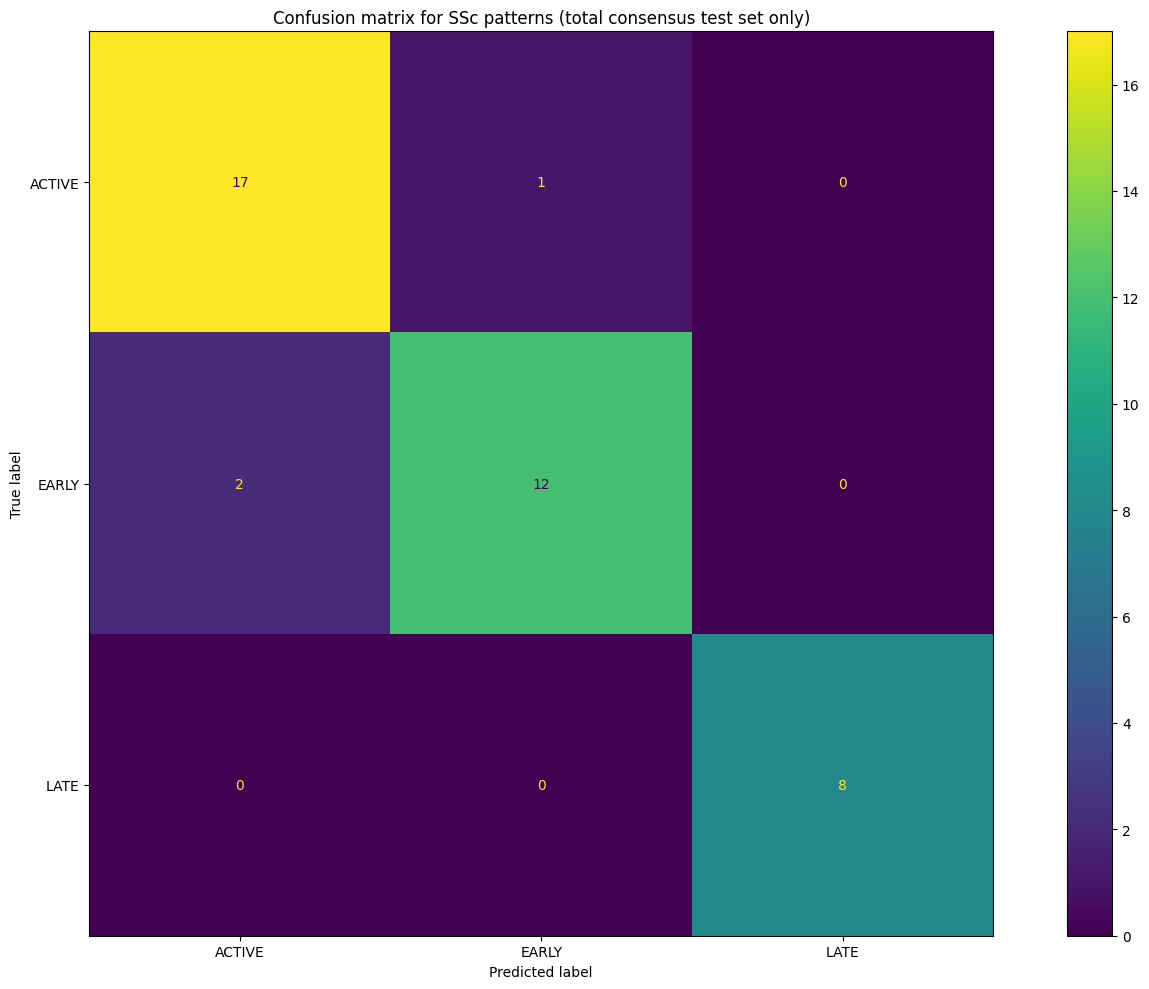

In [25]:
predicted_ssc_total_consensus = model_ssc.predict(X_test_ssc_total_consensus)
cm_ssc_total_consensus = confusion_matrix(y_test_ssc_total_consensus, predicted_ssc_total_consensus)

disp_ssc_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_ssc_total_consensus, display_labels=classes_ssc)
disp_ssc_total_consensus.plot()
plt.title('Confusion matrix for SSc patterns (total consensus test set only)')
plt.show()

# Train Capi-Detect Non-SSC type model

In [26]:
train_capis_non_ssc = train_capis.copy()
train_capis_non_ssc = train_capis_non_ssc[train_capis_non_ssc['gold'].isin(['NORMAL', 'NON_SPECIFIC'])]

test_capis_non_ssc = test_capis.copy()
test_capis_non_ssc = test_capis_non_ssc[test_capis_non_ssc['gold'].isin(['NORMAL', 'NON_SPECIFIC'])]

test_capis_non_ssc_total_consensus = test_capis_total_consensus.copy()
test_capis_non_ssc_total_consensus = test_capis_non_ssc_total_consensus[test_capis_non_ssc_total_consensus['gold'].isin(['NORMAL', 'NON_SPECIFIC'])]

print('Total capis for non-SSC:', len(train_capis_non_ssc))

train_capis_non_ssc.gold.value_counts()

Total capis for non-SSC: 788


gold
NON_SPECIFIC    444
NORMAL          344
Name: count, dtype: int64

In [27]:
X_train_non_ssc = train_capis_non_ssc.drop('gold', axis=1)
y_train_non_ssc = train_capis_non_ssc.gold

X_test_non_ssc = test_capis_non_ssc.drop('gold', axis=1)
y_test_non_ssc = test_capis_non_ssc.gold

X_test_non_ssc_total_consensus = test_capis_non_ssc_total_consensus.drop('gold', axis=1)
y_test_non_ssc_total_consensus = test_capis_non_ssc_total_consensus.gold

classes_non_ssc = np.unique(y_train_non_ssc)
weights_non_ssc = compute_class_weight(class_weight='balanced', classes=classes_non_ssc, y=y_train_non_ssc)
class_weights_non_ssc = dict(zip(classes_non_ssc, weights_non_ssc))

print(class_weights_non_ssc)

print('Train examples')
print(len(y_train_non_ssc[y_train_non_ssc == 'NORMAL']))
print(len(y_train_non_ssc[y_train_non_ssc == 'NON_SPECIFIC']))

print('Test examples')
print(len(y_test_non_ssc[y_test_non_ssc == 'NORMAL']))
print(len(y_test_non_ssc[y_test_non_ssc == 'NON_SPECIFIC']))
print('Test examples (total consensus)')
print(len(y_test_non_ssc_total_consensus[y_test_non_ssc_total_consensus == 'NORMAL']))
print(len(y_test_non_ssc_total_consensus[y_test_non_ssc_total_consensus == 'NON_SPECIFIC']))

{'NON_SPECIFIC': 0.8873873873873874, 'NORMAL': 1.1453488372093024}
Train examples
344
444
Test examples
83
114
Test examples (total consensus)
26
34


In [28]:
model_non_ssc = CatBoostClassifier(
    random_state=rand_seed,
    depth=6,
    learning_rate=0.0003,
    iterations=30000,
    logging_level='Silent'
)

train_pool_non_ssc = Pool(X_train_non_ssc, y_train_non_ssc)
validate_pool_non_ssc = Pool(X_test_non_ssc, y_test_non_ssc)

model_non_ssc.fit(
    train_pool_non_ssc,
    eval_set=validate_pool_non_ssc,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
y_pred_non_ssc = model_non_ssc.predict(X_test_non_ssc)
print("Capi-Detect Non-SSC model accuracy:", accuracy_score(y_test_non_ssc, y_pred_non_ssc))
print(classification_report(y_test_non_ssc, y_pred_non_ssc))

Capi-Detect Non-SSC model accuracy: 0.7461928934010152
              precision    recall  f1-score   support

NON_SPECIFIC       0.77      0.81      0.79       114
      NORMAL       0.71      0.66      0.69        83

    accuracy                           0.75       197
   macro avg       0.74      0.73      0.74       197
weighted avg       0.74      0.75      0.74       197



In [30]:
y_pred_non_ssc_total_consensus = model_non_ssc.predict(X_test_non_ssc_total_consensus)
print("Capi-Detect Non-SSC model accuracy (total consensus only):", accuracy_score(y_test_non_ssc_total_consensus, y_pred_non_ssc_total_consensus))
print(classification_report(y_test_non_ssc_total_consensus, y_pred_non_ssc_total_consensus))

Capi-Detect Non-SSC model accuracy (total consensus only): 0.9333333333333333
              precision    recall  f1-score   support

NON_SPECIFIC       0.89      1.00      0.94        34
      NORMAL       1.00      0.85      0.92        26

    accuracy                           0.93        60
   macro avg       0.95      0.92      0.93        60
weighted avg       0.94      0.93      0.93        60



In [31]:
feature_importances_non_ssc = model_non_ssc.get_feature_importance(train_pool_non_ssc)
feature_names_non_ssc = X_train_non_ssc.columns
feature_importances_map_non_ssc = {}
top_features_non_ssc = []
for score, name in sorted(zip(feature_importances_non_ssc, feature_names_non_ssc), reverse=True):
    top_features_non_ssc.append(name)
    feature_importances_map_non_ssc[name] = score
    print('{}: {}'.format(name, score))

hemorrhage_area_density: 13.36769763003984
hemorrhage_density: 10.929633790127012
all_density: 6.957334897787018
all_area_density: 6.808528671023998
enlarged_apical_diameter_avg: 6.264909446622324
abnormal_area_density: 5.493744800429901
abnormal_percent: 4.857178616937178
tortuosity_percent: 4.808242579676798
tortuosity_area_density: 3.9633083078535685
enlarged_area_density: 3.514499518113565
enlarged_limb_width_avg: 3.4816963993660583
tortuosity_density: 3.318204360653321
abnormal_density: 3.241139585857286
tortuosity_apical_diameter_avg: 3.042096384221681
enlarged_percent: 2.9537065135676572
all_limb_width_avg: 2.625971894052247
tortuosity_limb_width_avg: 2.6107784185171545
enlarged_density: 2.587922276392953
all_apical_diameter_avg: 2.2430106041402995
giant_limb_width_avg: 2.0911873578494187
giant_area_density: 1.571659930360704
giant_apical_diameter_avg: 1.4426981745432979
giant_percent: 1.133582665201079
giant_density: 0.6912671766656288


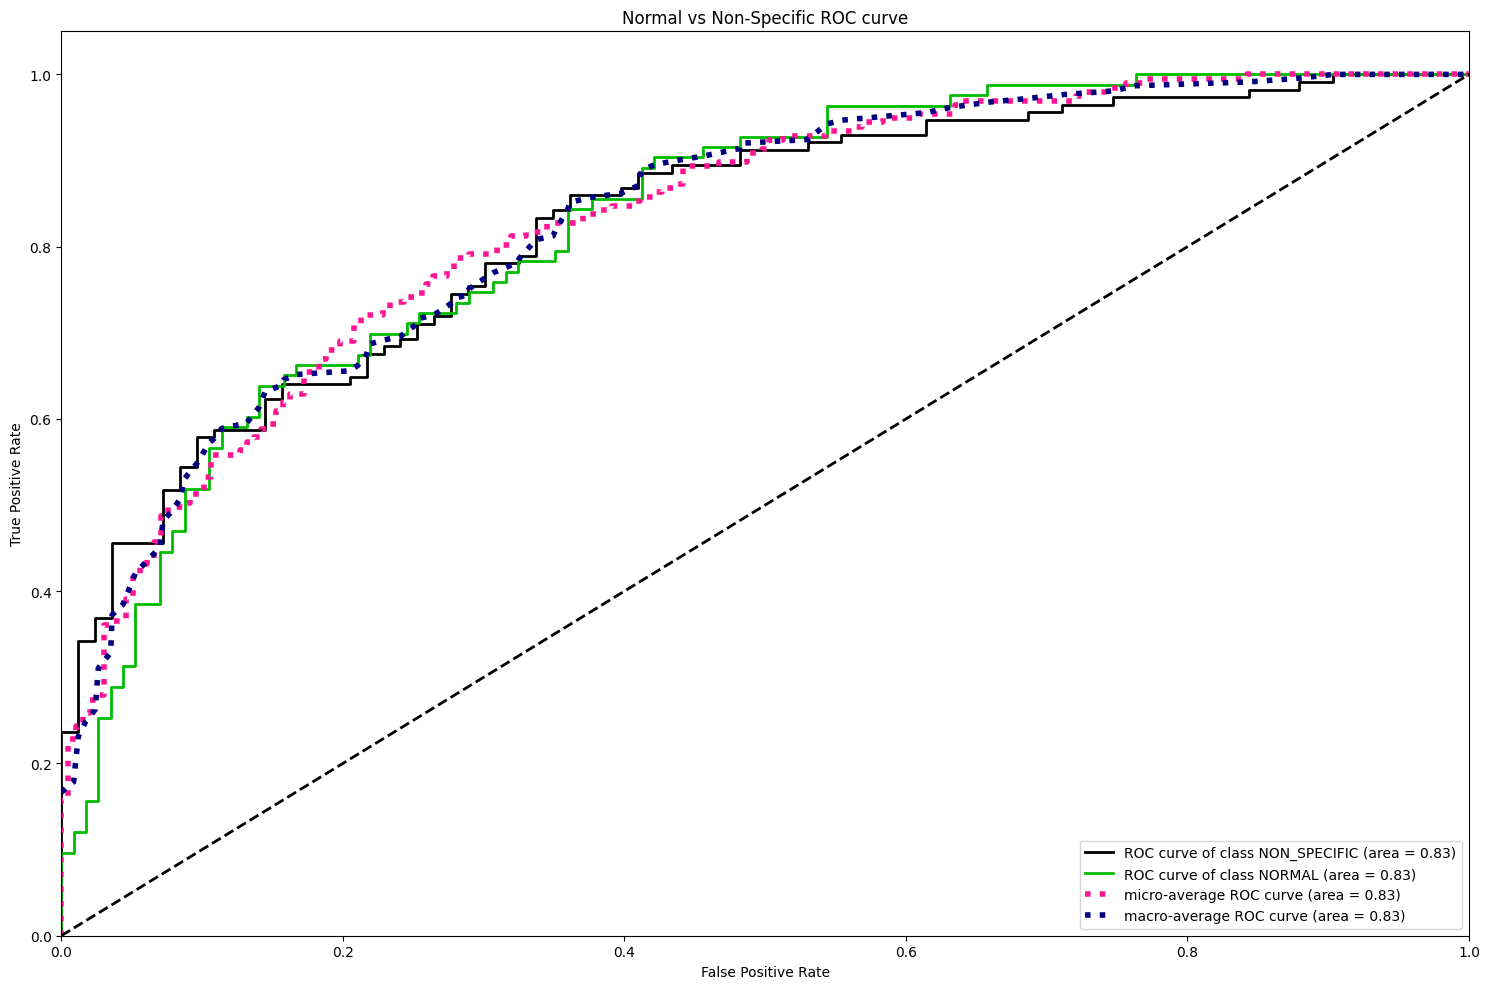

In [32]:
y_probas_non_ssc = model_non_ssc.predict_proba(X_test_non_ssc)
skplt.metrics.plot_roc(y_test_non_ssc, y_probas_non_ssc, cmap='nipy_spectral')
plt.title('Normal vs Non-Specific ROC curve')
plt.savefig('roc_non_ssc.svg')
plt.savefig('roc_non_ssc.png', dpi=300)
plt.show()

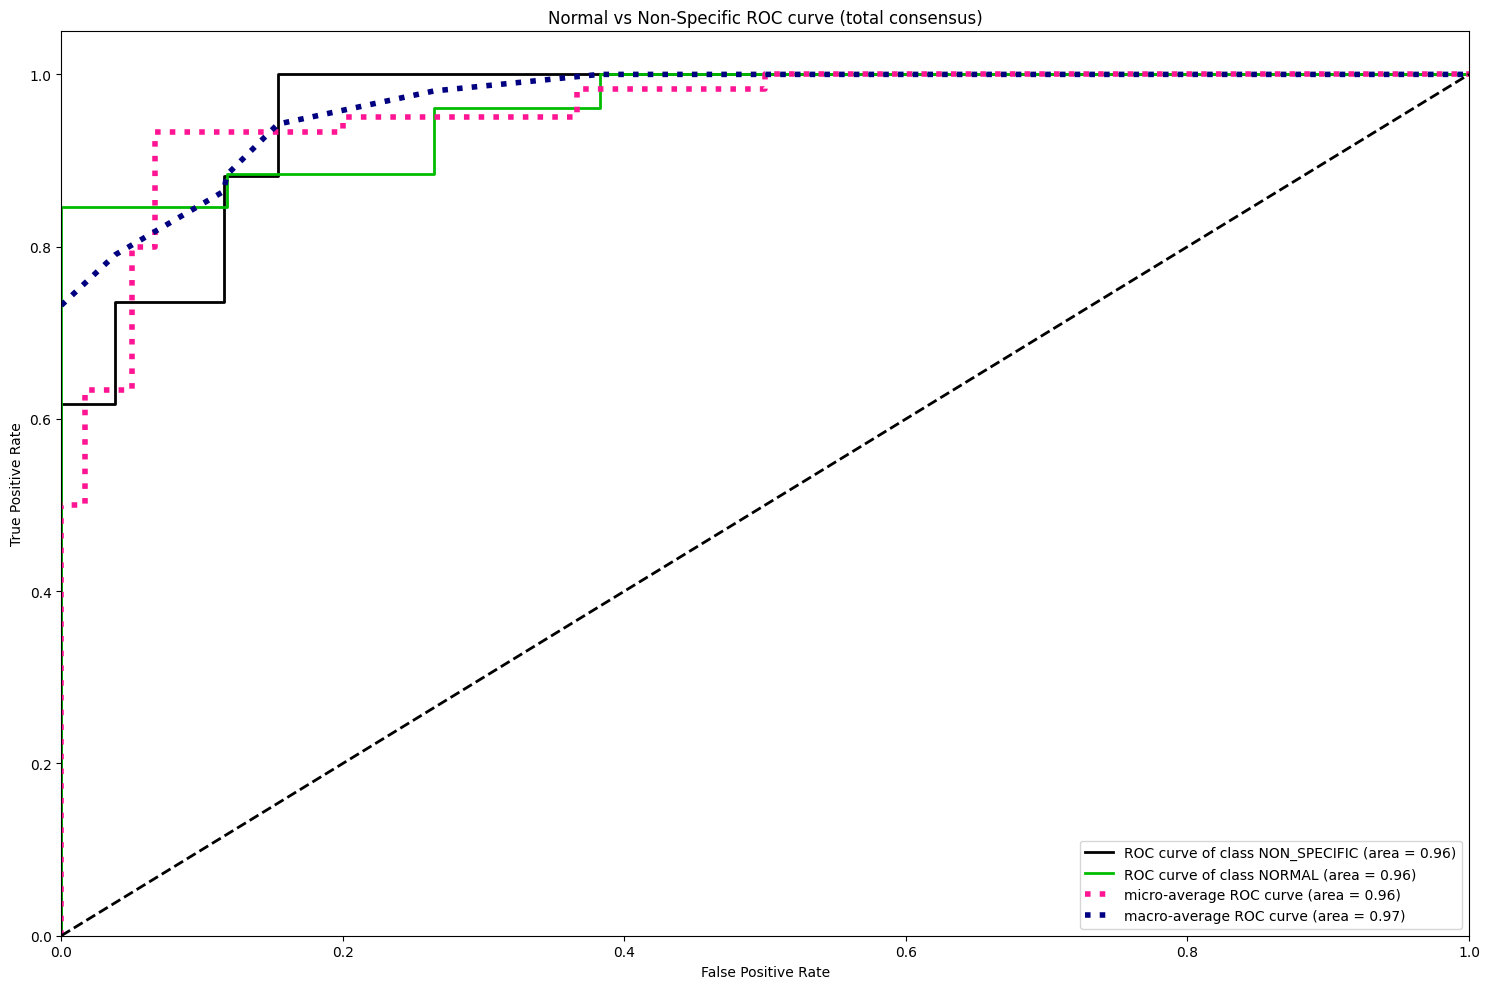

In [33]:
y_probas_non_ssc_total_consensus = model_non_ssc.predict_proba(X_test_non_ssc_total_consensus)
skplt.metrics.plot_roc(y_test_non_ssc_total_consensus, y_probas_non_ssc_total_consensus, cmap='nipy_spectral')
plt.title('Normal vs Non-Specific ROC curve (total consensus)')
plt.savefig('roc_non_ssc_total_consensus.svg')
plt.savefig('roc_non_ssc_total_consensus.png', dpi=300)
plt.show()

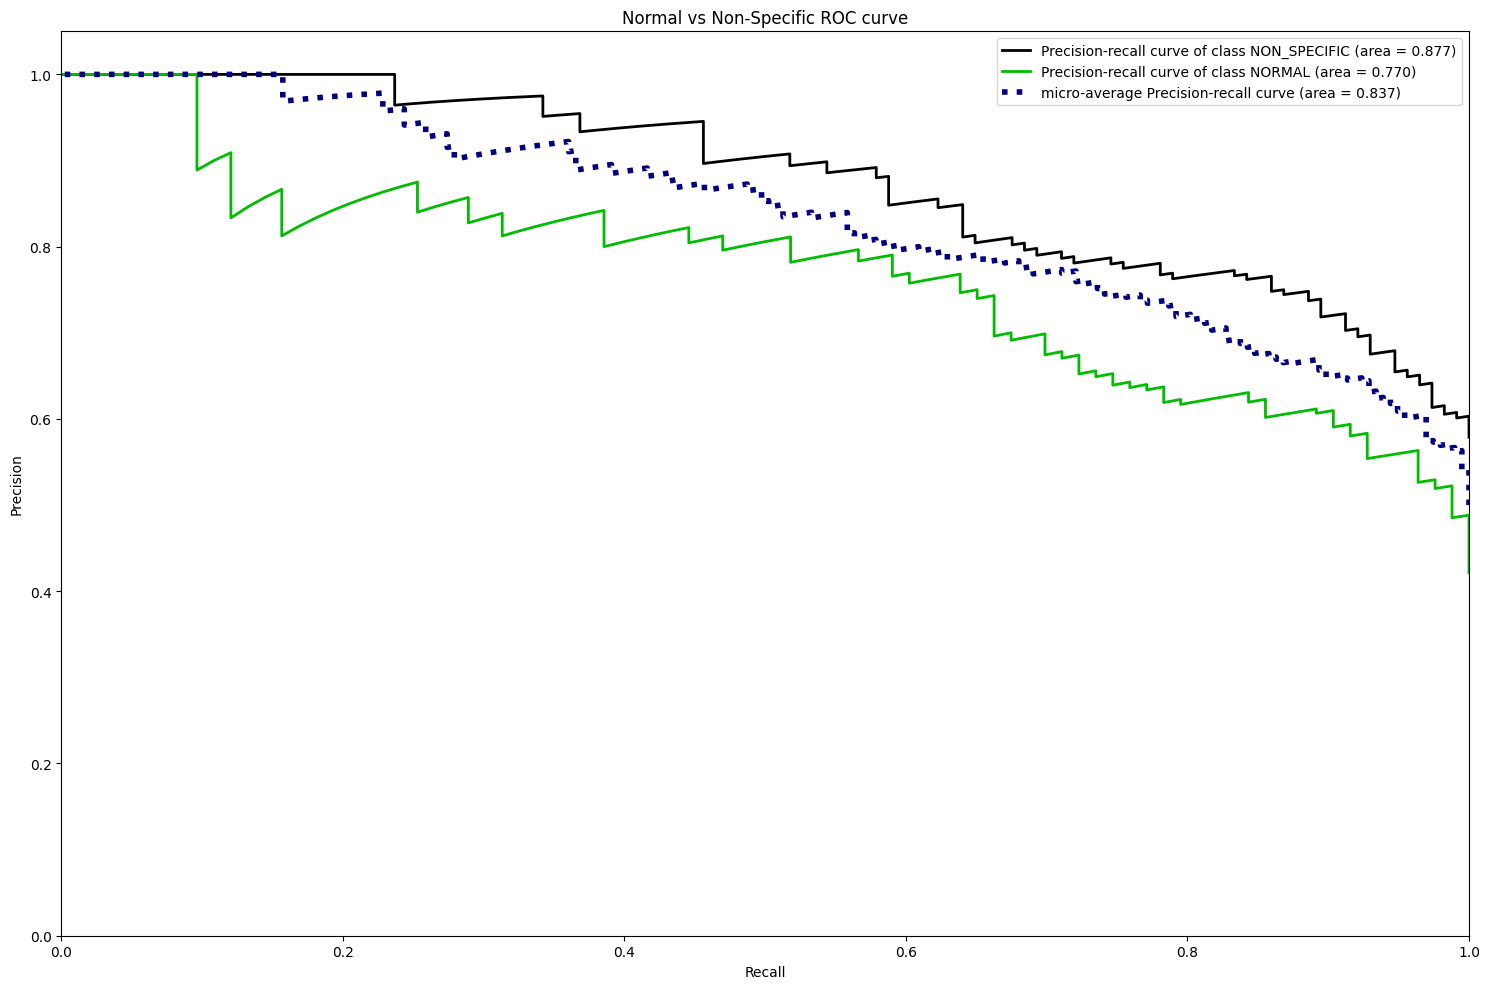

In [34]:
y_probas_non_ssc = model_non_ssc.predict_proba(X_test_non_ssc)
skplt.metrics.plot_precision_recall(y_test_non_ssc, y_probas_non_ssc, cmap='nipy_spectral')
plt.title('Normal vs Non-Specific ROC curve')
plt.savefig('pr_non_ssc.svg')
plt.savefig('pr_non_ssc.png', dpi=300)
plt.show()

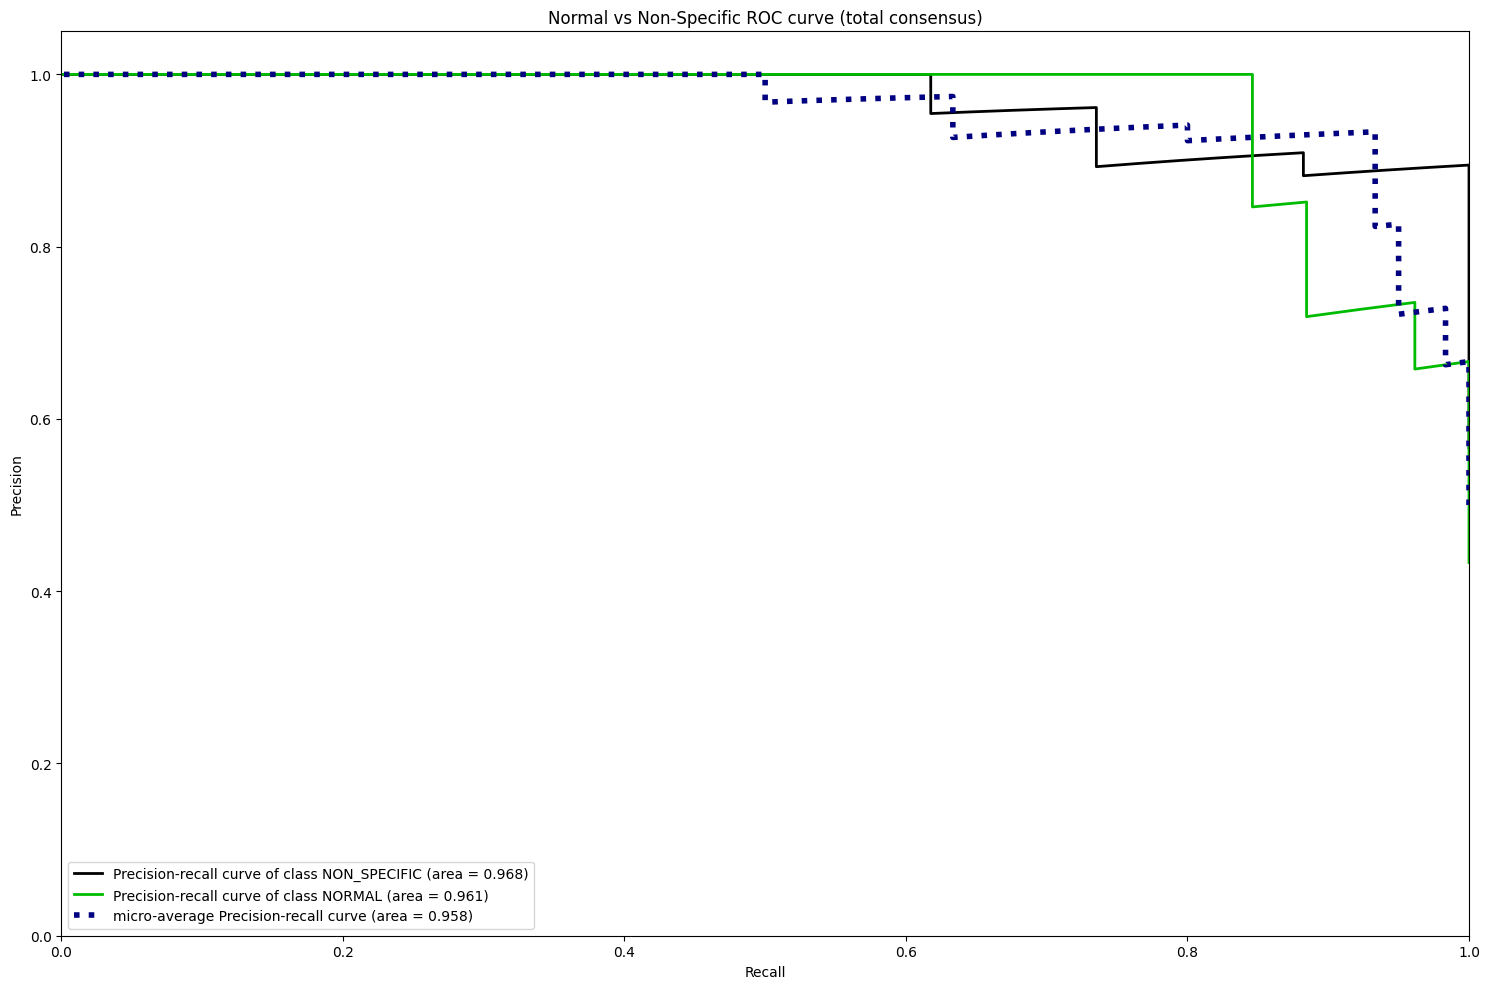

In [35]:
y_probas_non_ssc_total_consensus = model_non_ssc.predict_proba(X_test_non_ssc_total_consensus)
skplt.metrics.plot_precision_recall(y_test_non_ssc_total_consensus, y_probas_non_ssc_total_consensus, cmap='nipy_spectral')
plt.title('Normal vs Non-Specific ROC curve (total consensus)')
plt.savefig('pr_non_ssc_total_consensus.svg')
plt.savefig('pr_non_ssc_total_consensus.png', dpi=300)
plt.show()

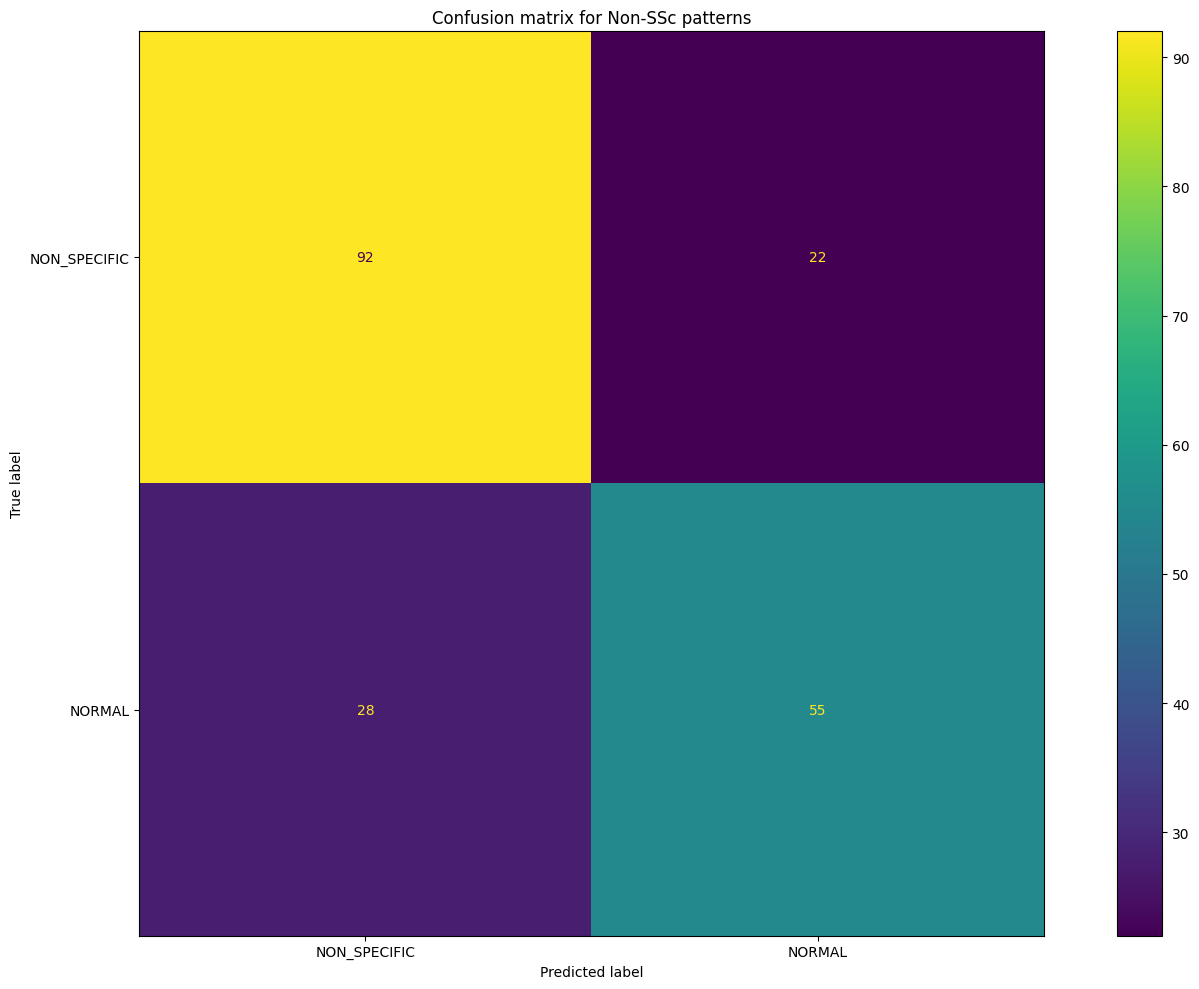

In [36]:
predicted_non_ssc = model_non_ssc.predict(X_test_non_ssc)
cm_non_ssc = confusion_matrix(y_test_non_ssc, predicted_non_ssc)

disp_non_ssc = ConfusionMatrixDisplay(confusion_matrix=cm_non_ssc, display_labels=classes_non_ssc)
disp_non_ssc.plot()
plt.title('Confusion matrix for Non-SSc patterns')
plt.show()

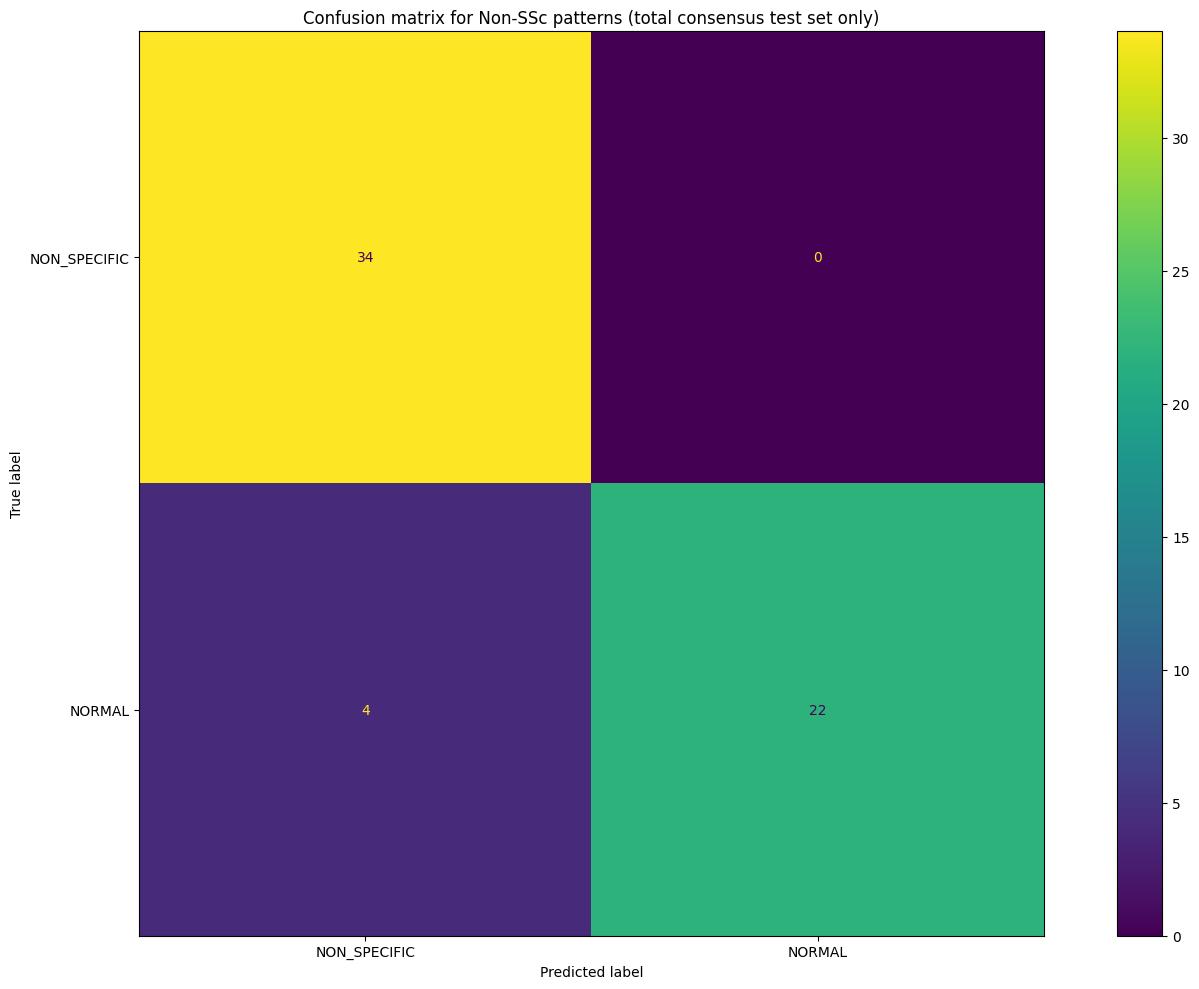

In [37]:
predicted_non_ssc_total_consensus = model_non_ssc.predict(X_test_non_ssc_total_consensus)
cm_non_ssc_total_consensus = confusion_matrix(y_test_non_ssc_total_consensus, predicted_non_ssc_total_consensus)

disp_non_ssc_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_non_ssc_total_consensus, display_labels=classes_non_ssc)
disp_non_ssc_total_consensus.plot()
plt.title('Confusion matrix for Non-SSc patterns (total consensus test set only)')
plt.show()

# Capi-Detect 5-way matrices performance

In [38]:
test_capis_5way = test_capis.copy()
test_capis_5way.gold.value_counts()

gold
NON_SPECIFIC    114
NORMAL           83
EARLY            45
ACTIVE           39
LATE             17
Name: count, dtype: int64

In [39]:
test_capis_5way_total_consensus = test_capis_total_consensus.copy()
test_capis_5way_total_consensus.gold.value_counts()

gold
NON_SPECIFIC    34
NORMAL          26
ACTIVE          18
EARLY           14
LATE             8
Name: count, dtype: int64

In [40]:
from sklearn.base import BaseEstimator, ClassifierMixin
class Model5Way(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        preds = []

        preds_ssc_or_not = model.predict(X).flatten()
        preds_ssc_type = model_ssc.predict(X).flatten()
        preds_non_ssc = model_non_ssc.predict(X).flatten()

        for index in range(len(X)):            
            if preds_ssc_or_not[index] == 'SSC':
                preds.append(preds_ssc_type[index])
            else:
                preds.append(preds_non_ssc[index])
                
        return preds
    
    def predict_proba(self, X, y=None):
        pass
    

In [41]:
X_test_5way = test_capis_5way.drop('gold', axis=1)
y_test_5way = test_capis_5way.gold

classes_5way = np.unique(y_test_5way)
model_5way = Model5Way()

predicted_5way = model_5way.predict(X_test_5way)

print("Capi-Detect 5-way model accuracy:", accuracy_score(y_test_5way, predicted_5way))
print(classification_report(y_test_5way, predicted_5way))

Capi-Detect 5-way model accuracy: 0.6812080536912751
              precision    recall  f1-score   support

      ACTIVE       0.76      0.74      0.75        39
       EARLY       0.62      0.58      0.60        45
        LATE       0.73      0.65      0.69        17
NON_SPECIFIC       0.66      0.72      0.69       114
      NORMAL       0.70      0.66      0.68        83

    accuracy                           0.68       298
   macro avg       0.69      0.67      0.68       298
weighted avg       0.68      0.68      0.68       298



In [42]:
X_test_5way_total_consensus = test_capis_5way_total_consensus.drop('gold', axis=1)
y_test_5way_total_consensus = test_capis_5way_total_consensus.gold

classes_5way = np.unique(y_test_5way_total_consensus)
model_5way = Model5Way()

predicted_5way_total_consensus = model_5way.predict(X_test_5way_total_consensus)

print("Capi-Detect 5-way model accuracy (total consensus only):", accuracy_score(y_test_5way_total_consensus, predicted_5way_total_consensus))
print(classification_report(y_test_5way_total_consensus, predicted_5way_total_consensus))

Capi-Detect 5-way model accuracy (total consensus only): 0.84
              precision    recall  f1-score   support

      ACTIVE       0.89      0.94      0.92        18
       EARLY       0.56      0.64      0.60        14
        LATE       1.00      1.00      1.00         8
NON_SPECIFIC       0.82      0.82      0.82        34
      NORMAL       0.96      0.85      0.90        26

    accuracy                           0.84       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.84      0.84       100



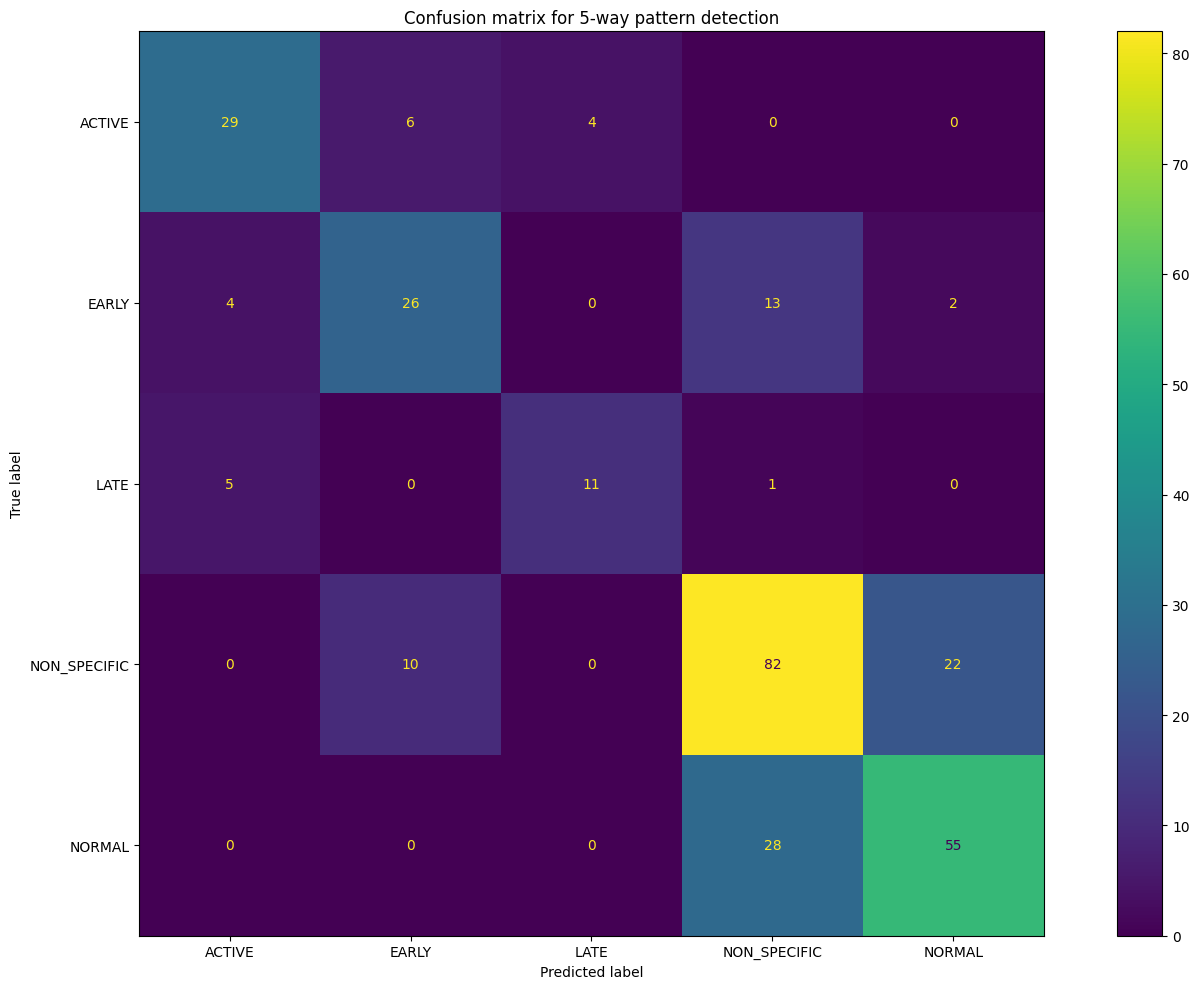

In [43]:
cm_5way = confusion_matrix(y_test_5way, predicted_5way)

disp_5way = ConfusionMatrixDisplay(confusion_matrix=cm_5way, display_labels=classes_5way)
disp_5way.plot()
plt.title('Confusion matrix for 5-way pattern detection')
plt.show()

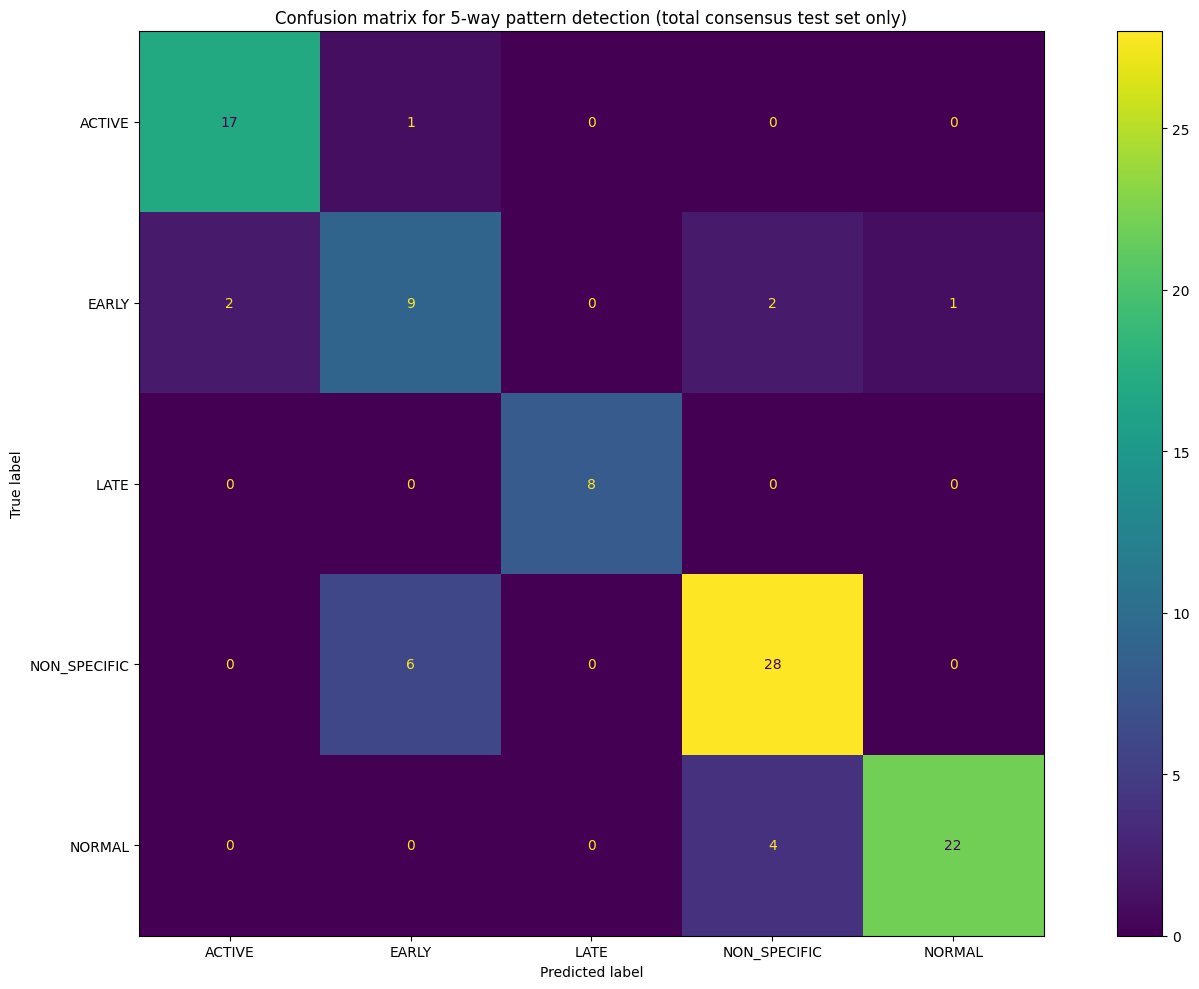

In [44]:
cm_5way_total_consensus = confusion_matrix(y_test_5way_total_consensus, predicted_5way_total_consensus)

disp_5way_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_5way_total_consensus, display_labels=classes_5way)
disp_5way_total_consensus.plot()
plt.title('Confusion matrix for 5-way pattern detection (total consensus test set only)')
plt.show()

# Capi-Score performance

In [45]:
class CapiScoreSScOrNotSSc(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        preds = []
        for index, row in X.iterrows():
            preds.append(self.pred_row(row))
            
        return preds

    def pred_row(self, row):
        if row.all_density <= 6 or row.giant_percent >= 1 or row.abnormal_percent >= 10:
            return 'SSC'
        else:
            return 'NORMAL'
    
    def predict_proba(self, X, y=None):
        pass

class CapiScore5Way(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        pass
    
    def predict(self, X, y=None):
        preds = []
        for index, row in X.iterrows():
            preds.append(self.pred_row(row))
            
        return preds

    def pred_row(self, row):
        if row.all_density <= 6 or row.giant_percent >= 1 or row.abnormal_percent >= 10:
            # Density 5 or more:

            if row.all_density >= 5:            
                if row.giant_percent >= 10 or row.abnormal_percent >= 5:
                    return 'ACTIVE'
                
                return 'EARLY'
            
            # Density 5 or less:
            
            if row.abnormal_percent >= 15:
                return 'LATE'
            
            if row.giant_percent >= 33:
                return 'ACTIVE'
                    
            if row.abnormal_percent <= 7 and row.giant_percent >= 7:
                return 'ACTIVE'
    
            return 'LATE'
        else:
            # Density 6 or more:
    
            if row.all_density >= 6:
                if row.tortuosity_percent >= 20 or row.hemorrhage_density >= 0.1 or row.abnormal_percent >= 2:
                    return 'NON_SPECIFIC'
                
                return 'NORMAL'
            
            # Density 6 or less:
            
            if row.tortuosity_percent >= 5 or row.abnormal_percent >= 1:
                return 'NON_SPECIFIC'

        return 'NORMAL'
    
    def predict_proba(self, X, y=None):
        pass

model_capiscore_ssc_or_not = CapiScoreSScOrNotSSc()
model_capiscore_5way = CapiScore5Way()

In [46]:
predicted_capiscore = model_capiscore_ssc_or_not.predict(X_test)

print("CAPI-Score SSc vs Non-SSC accuracy:", accuracy_score(y_test, predicted_capiscore))
print(classification_report(y_test, predicted_capiscore))

CAPI-Score SSc vs Non-SSC accuracy: 0.8758389261744967
              precision    recall  f1-score   support

      NORMAL       0.92      0.89      0.90       197
         SSC       0.80      0.85      0.82       101

    accuracy                           0.88       298
   macro avg       0.86      0.87      0.86       298
weighted avg       0.88      0.88      0.88       298



In [47]:
predicted_capiscore_total_consensus = model_capiscore_ssc_or_not.predict(X_test_total_consensus)

print("CAPI-Score SSc vs Non-SSC accuracy (total consensus only):", accuracy_score(y_test_total_consensus, predicted_capiscore_total_consensus))
print(classification_report(y_test_total_consensus, predicted_capiscore_total_consensus))

CAPI-Score SSc vs Non-SSC accuracy (total consensus only): 0.86
              precision    recall  f1-score   support

      NORMAL       0.94      0.82      0.88        60
         SSC       0.77      0.93      0.84        40

    accuracy                           0.86       100
   macro avg       0.86      0.87      0.86       100
weighted avg       0.87      0.86      0.86       100



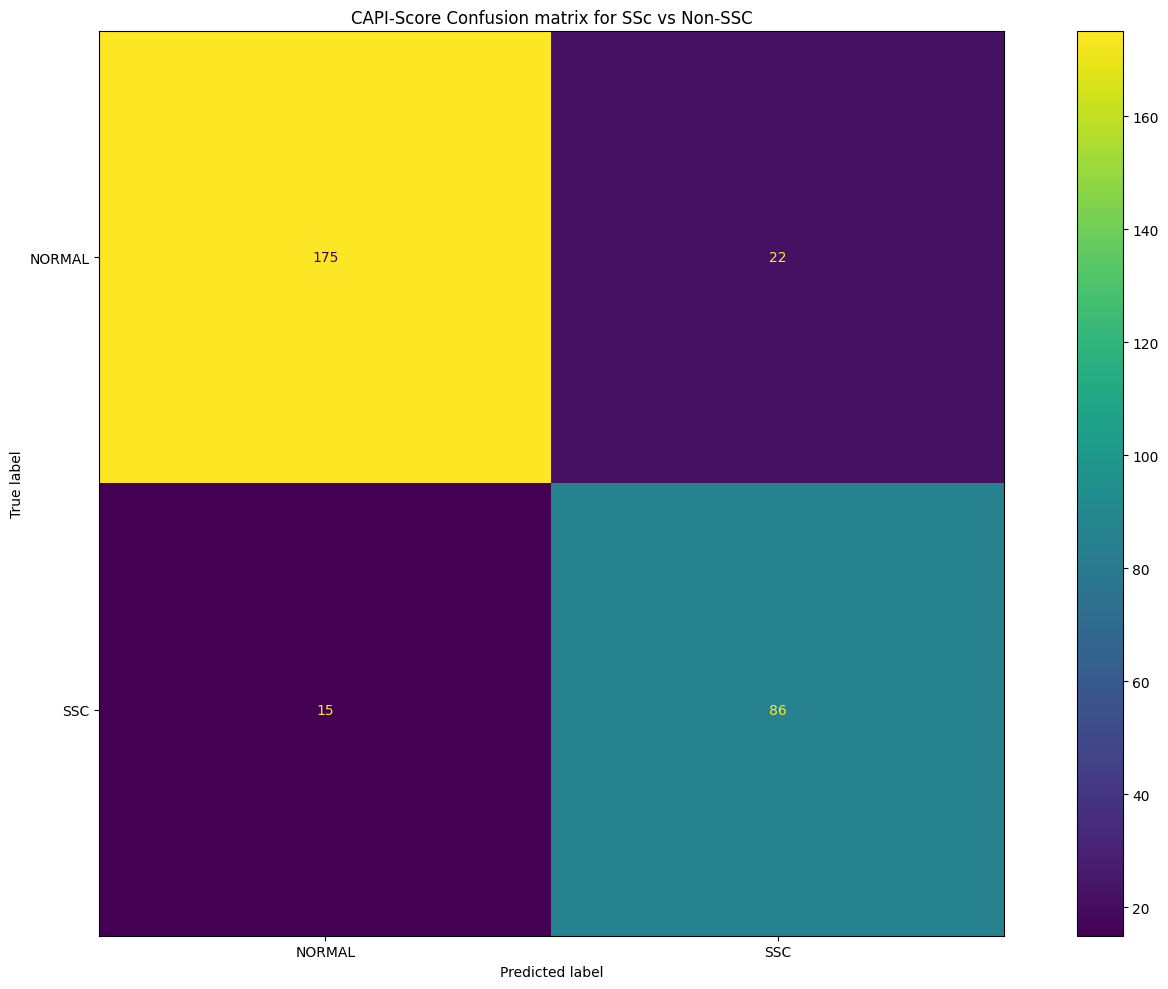

In [48]:
cm_capiscore_ssc_vs_not_ssc = confusion_matrix(y_test, predicted_capiscore)

disp_capiscore_ssc_vs_not_ssc = ConfusionMatrixDisplay(confusion_matrix=cm_capiscore_ssc_vs_not_ssc, display_labels=classes)
disp_capiscore_ssc_vs_not_ssc.plot()
plt.title('CAPI-Score Confusion matrix for SSc vs Non-SSC')
plt.show()

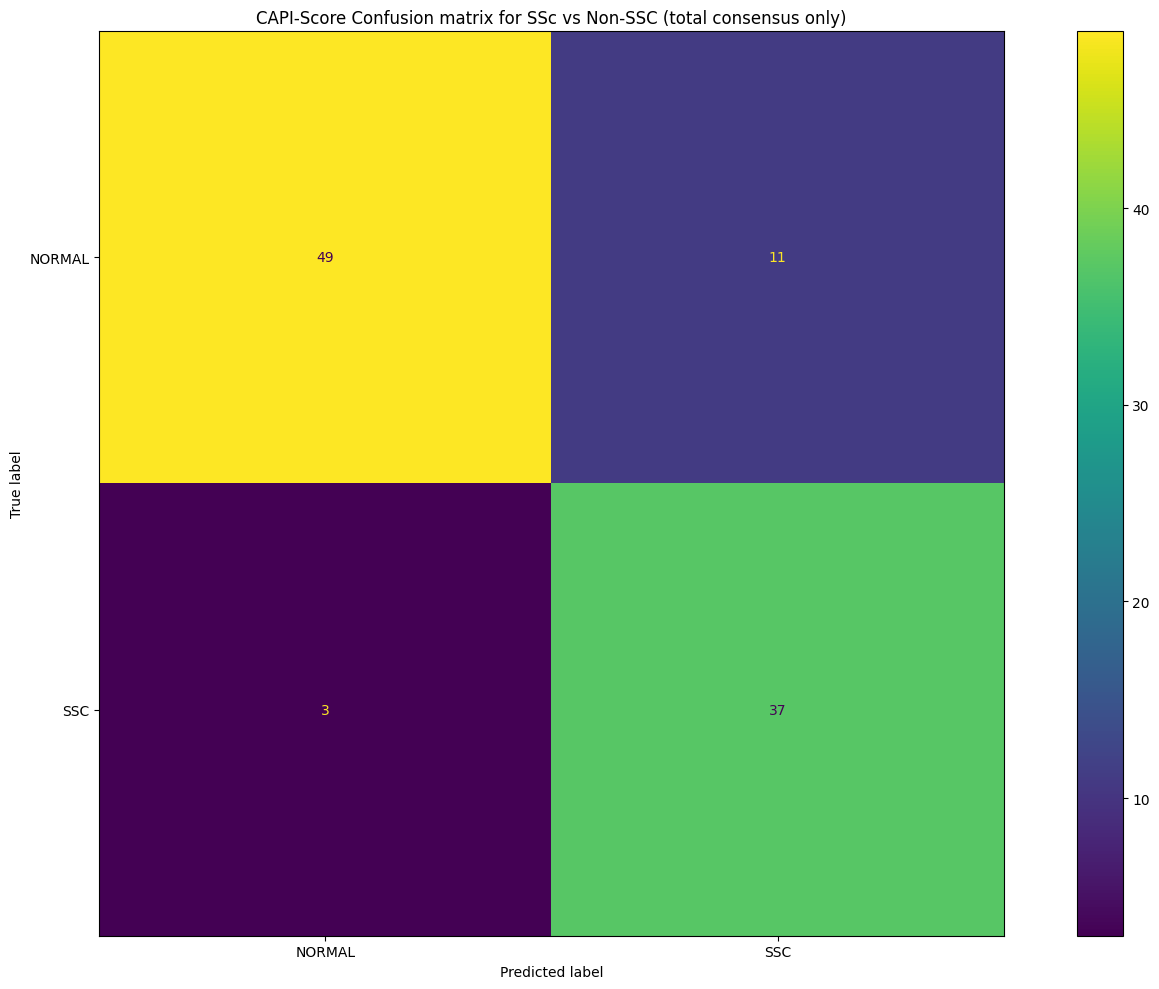

In [49]:
cm_capiscore_ssc_vs_not_ssc_total_consensus = confusion_matrix(y_test_total_consensus, predicted_capiscore_total_consensus)

disp_capiscore_ssc_vs_not_ssc_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_capiscore_ssc_vs_not_ssc_total_consensus, display_labels=classes)
disp_capiscore_ssc_vs_not_ssc_total_consensus.plot()
plt.title('CAPI-Score Confusion matrix for SSc vs Non-SSC (total consensus only)')
plt.show()

In [50]:
predicted_capiscore_5way = model_capiscore_5way.predict(X_test_5way)

print("CAPI-Score 5-way model accuracy:", accuracy_score(y_test_5way, predicted_capiscore_5way))
print(classification_report(y_test_5way, predicted_capiscore_5way))

CAPI-Score 5-way model accuracy: 0.6476510067114094
              precision    recall  f1-score   support

      ACTIVE       0.72      0.74      0.73        39
       EARLY       0.51      0.60      0.55        45
        LATE       0.67      0.59      0.62        17
NON_SPECIFIC       0.66      0.63      0.65       114
      NORMAL       0.68      0.66      0.67        83

    accuracy                           0.65       298
   macro avg       0.65      0.65      0.65       298
weighted avg       0.65      0.65      0.65       298



In [51]:
predicted_capiscore_5way_total_consensus = model_capiscore_5way.predict(X_test_5way_total_consensus)

print("CAPI-Score 5-way model accuracy (total consensus only):", accuracy_score(y_test_5way_total_consensus, predicted_capiscore_5way_total_consensus))
print(classification_report(y_test_5way_total_consensus, predicted_capiscore_5way_total_consensus))

CAPI-Score 5-way model accuracy (total consensus only): 0.78
              precision    recall  f1-score   support

      ACTIVE       0.89      0.94      0.92        18
       EARLY       0.55      0.79      0.65        14
        LATE       0.78      0.88      0.82         8
NON_SPECIFIC       0.74      0.68      0.71        34
      NORMAL       0.95      0.77      0.85        26

    accuracy                           0.78       100
   macro avg       0.78      0.81      0.79       100
weighted avg       0.80      0.78      0.78       100



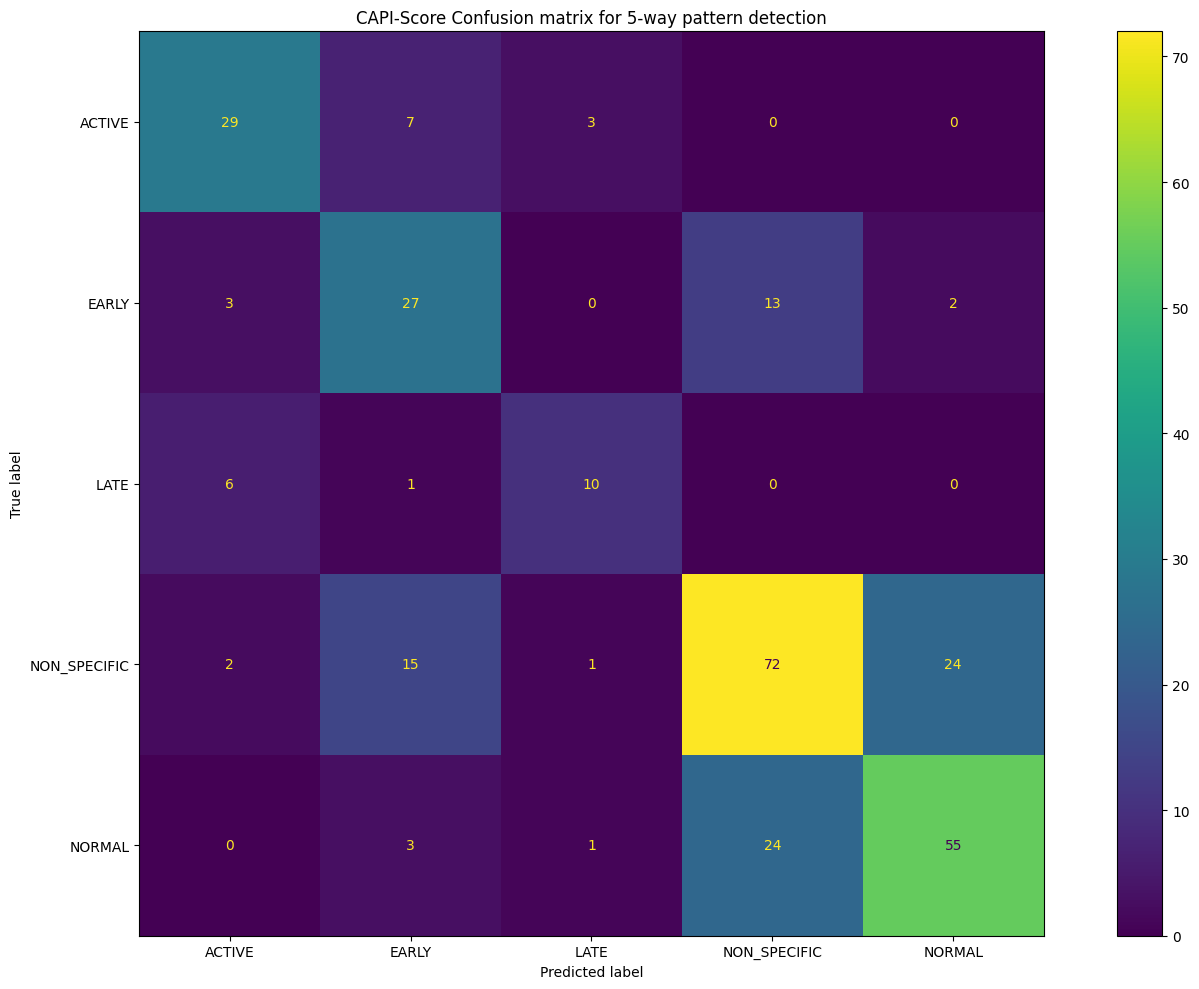

In [52]:
cm_capiscore_5way = confusion_matrix(y_test_5way, predicted_capiscore_5way)

disp_capiscore_5way = ConfusionMatrixDisplay(confusion_matrix=cm_capiscore_5way, display_labels=classes_5way)
disp_capiscore_5way.plot()
plt.title('CAPI-Score Confusion matrix for 5-way pattern detection')
plt.show()

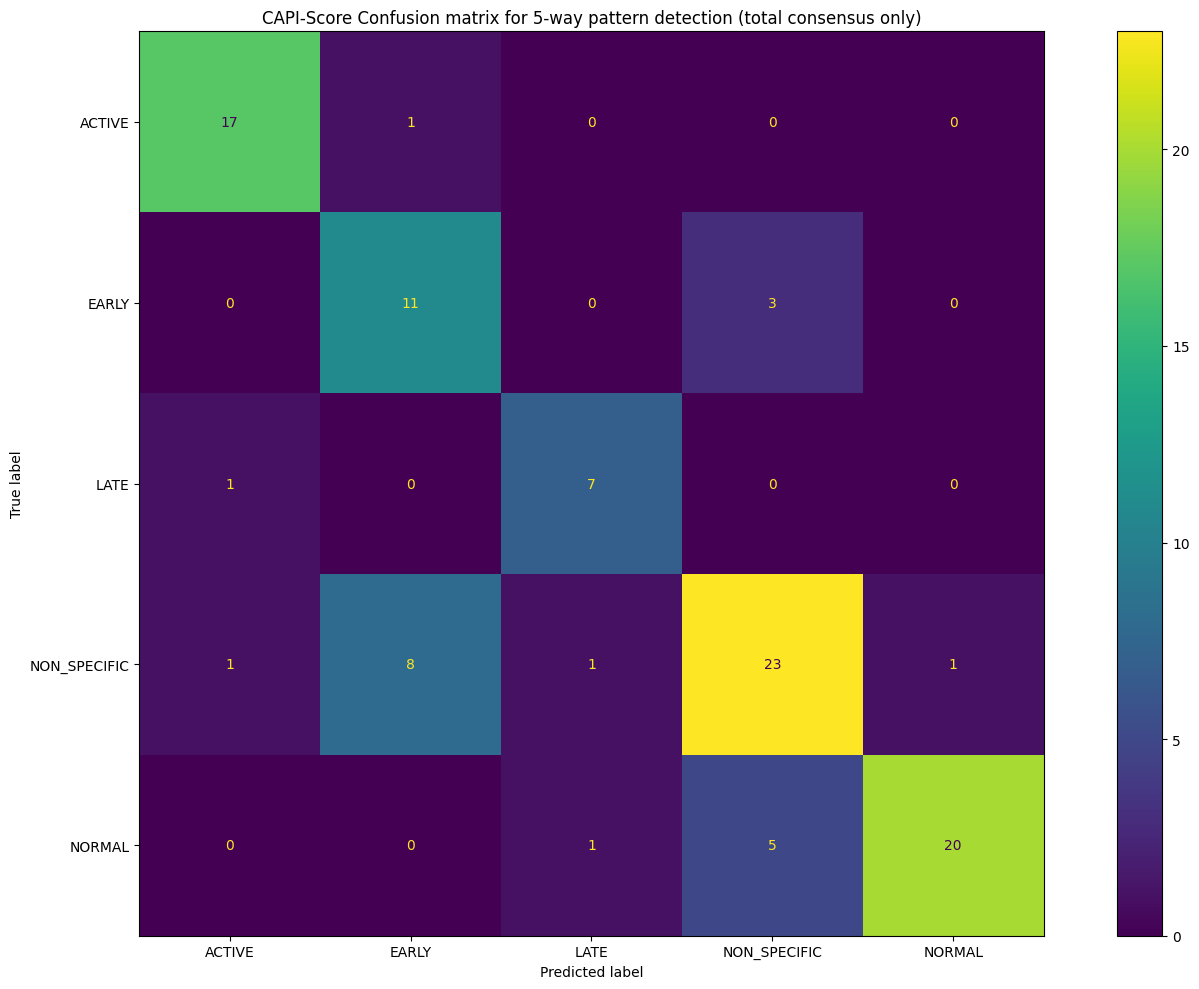

In [53]:
cm_capiscore_5way_total_consensus = confusion_matrix(y_test_5way_total_consensus, predicted_capiscore_5way_total_consensus)

disp_capiscore_5way_total_consensus = ConfusionMatrixDisplay(confusion_matrix=cm_capiscore_5way_total_consensus, display_labels=classes_5way)
disp_capiscore_5way_total_consensus.plot()
plt.title('CAPI-Score Confusion matrix for 5-way pattern detection (total consensus only)')
plt.show()

# Charts and figures

In [54]:
features = train_capis.columns.copy().drop(['gold'])
feature_name_map = {
    'all_density': 'All, density (cap/mm)',
    'all_apical_diameter_avg': 'All, MAD (µm)',
    'all_limb_width_avg': 'All, MLW (µm)',
    'all_area_density': 'All, area density (mm²/mm)',
    'enlarged_density': 'Enlarged, density (cap/mm)',
    'enlarged_percent': 'Enlarged (%)',
    'enlarged_apical_diameter_avg': 'Enlarged, MAD (µm)',
    'enlarged_limb_width_avg': 'Enlarged, MLW (µm)',
    'enlarged_area_density': 'Enlarged, area density (mm²/mm)',
    'giant_density': 'Giant, density (cap/mm)',
    'giant_percent': 'Giant (%)',
    'giant_apical_diameter_avg': 'Giant, MAD (µm)',
    'giant_limb_width_avg': 'Giant, limb width avg (µm)',
    'giant_area_density': 'Giant, area density (mm²/mm)',
    'tortuosity_density': 'Tortuosity, density (cap/mm)',
    'tortuosity_percent': 'Tortuosity (%)',
    'tortuosity_apical_diameter_avg': 'Tortuosity, MAD (µm)',
    'tortuosity_limb_width_avg': 'Tortuosity, MLW (µm)',
    'tortuosity_area_density': 'Tortuosity, area density (mm²/mm)',
    'abnormal_density': 'Abnormal, density (cap/mm)',
    'abnormal_percent': 'Abnormal (%)',
    'abnormal_area_density': 'Abnormal, area density (mm²/mm)',
    'hemorrhage_density': 'Hemorrhage, density (count/mm)',
    'hemorrhage_area_density': 'Hemorrhage, area density (mm²/mm)',
}

feature_names_list = [feature_name_map[x] for x in features]

## SSc vs Non-SSc most important features

In [55]:
capis_normal = capis.query('gold == "NORMAL"').drop(['gold'], axis = 'columns')
capis_non_specific = capis.query('gold == "NON_SPECIFIC"').drop(['gold'], axis = 'columns')
capis_early = capis.query('gold == "EARLY"').drop(['gold'], axis = 'columns')
capis_active = capis.query('gold == "ACTIVE"').drop(['gold'], axis = 'columns')
capis_late = capis.query('gold == "LATE"').drop(['gold'], axis = 'columns')

capis_ssc = pd.concat([capis_early, capis_active, capis_late])
capis_non_ssc = pd.concat([capis_normal, capis_non_specific])

In [56]:
print('Top 4 SSc vs Non-SSC features: ', [{'feature': x, 'importance': feature_importances_map[x]} for x in top_features[:4]])

Top 4 SSc vs Non-SSC features:  [{'feature': 'giant_percent', 'importance': 13.819793914952069}, {'feature': 'giant_area_density', 'importance': 10.486596180220108}, {'feature': 'enlarged_apical_diameter_avg', 'importance': 8.050880417813142}, {'feature': 'giant_density', 'importance': 7.241157452851418}]


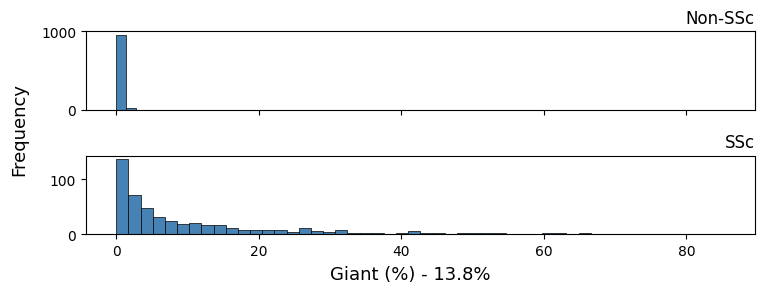

In [57]:
col='giant_percent'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_non_ssc[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Non-SSc', loc='right')

axs[1].hist(capis_ssc[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_or_not.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_or_not.png", dpi=300, bbox_inches="tight")

plt.show()

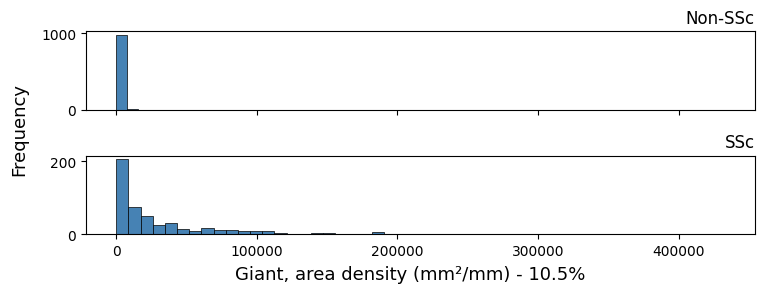

In [58]:
col='giant_area_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_non_ssc[col], bins=25, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Non-SSc', loc='right')

axs[1].hist(capis_ssc[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_or_not.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_or_not.png", dpi=300, bbox_inches="tight")

plt.show()

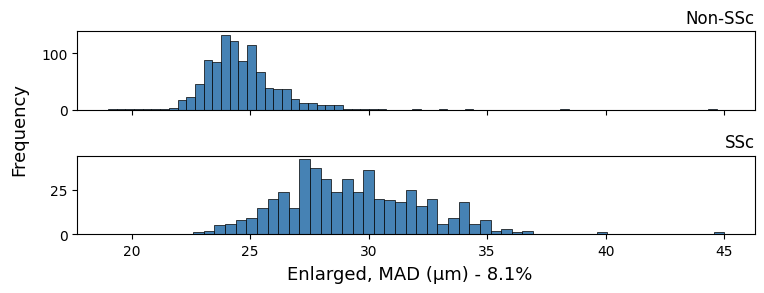

In [59]:
col='enlarged_apical_diameter_avg'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_non_ssc[col], bins=70, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Non-SSc', loc='right')

axs[1].hist(capis_ssc[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_or_not.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_or_not.png", dpi=300, bbox_inches="tight")

plt.show()

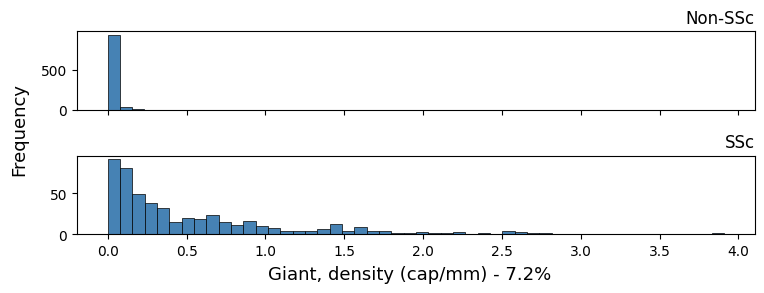

In [60]:
col='giant_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_non_ssc[col], bins=20, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Non-SSc', loc='right')

axs[1].hist(capis_ssc[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_or_not.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_or_not.png", dpi=300, bbox_inches="tight")

plt.show()

## SSc stage most important features

In [61]:
print('Top 4 SSc stage features: ', [{'feature': x, 'importance': feature_importances_map_ssc[x]} for x in top_features_ssc[:4]])

Top 4 SSc stage features:  [{'feature': 'all_density', 'importance': 15.265963352726738}, {'feature': 'giant_area_density', 'importance': 11.935188508313068}, {'feature': 'enlarged_density', 'importance': 9.489941439832222}, {'feature': 'abnormal_area_density', 'importance': 8.219001554380664}]


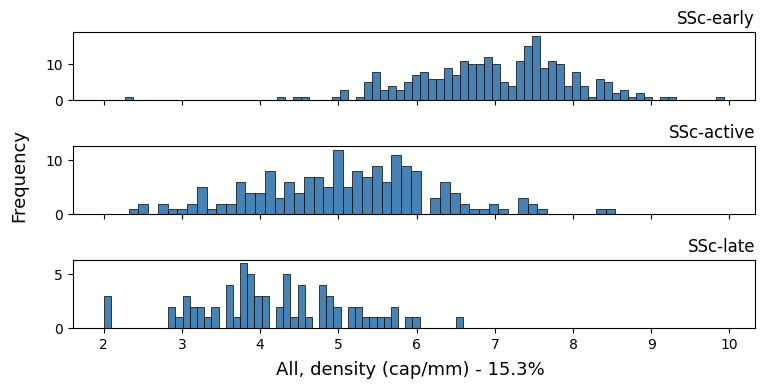

In [62]:
col='all_density'

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 4))

axs[0].hist(capis_early[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('SSc-early', loc='right')

axs[1].hist(capis_active[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc-active', loc='right')

axs[2].hist(capis_late[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[2].set_title('SSc-late', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_stage.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_stage.png", dpi=300, bbox_inches="tight")

plt.show()

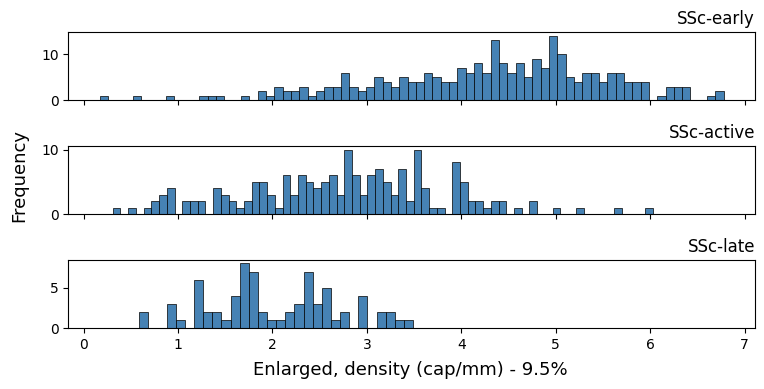

In [63]:
col='enlarged_density'

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 4))

axs[0].hist(capis_early[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('SSc-early', loc='right')

axs[1].hist(capis_active[col], bins=70, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc-active', loc='right')

axs[2].hist(capis_late[col], bins=30, edgecolor='black', linewidth=0.5, color='steelblue')
axs[2].set_title('SSc-late', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_stage.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_stage.png", dpi=300, bbox_inches="tight")

plt.show()

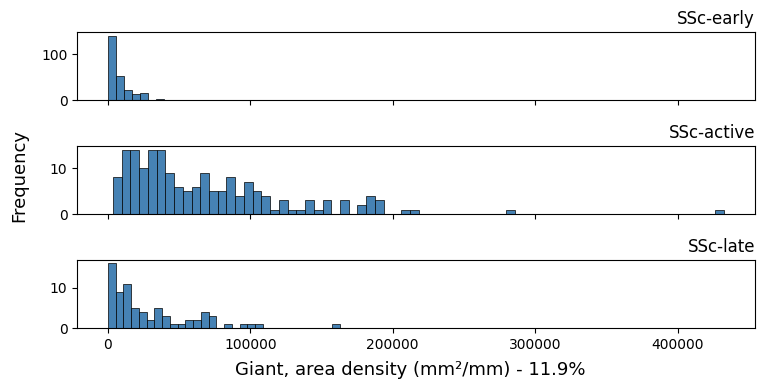

In [64]:
col='giant_area_density'

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 4))

axs[0].hist(capis_early[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('SSc-early', loc='right')

axs[1].hist(capis_active[col], bins=70, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc-active', loc='right')

axs[2].hist(capis_late[col], bins=30, edgecolor='black', linewidth=0.5, color='steelblue')
axs[2].set_title('SSc-late', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_stage.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_stage.png", dpi=300, bbox_inches="tight")

plt.show()

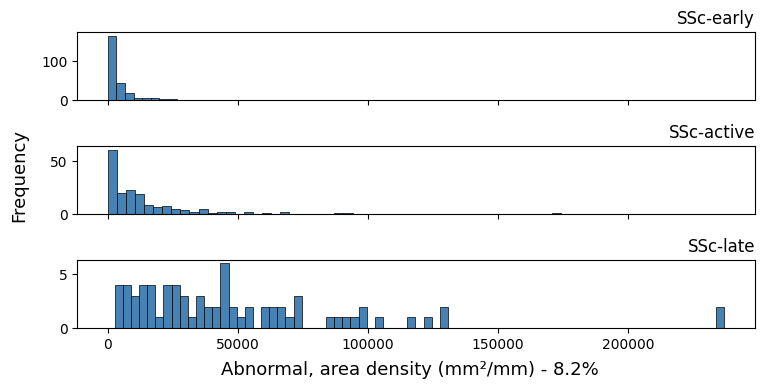

In [65]:
col='abnormal_area_density'

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 4))

axs[0].hist(capis_early[col], bins=15, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('SSc-early', loc='right')

axs[1].hist(capis_active[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('SSc-active', loc='right')

axs[2].hist(capis_late[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[2].set_title('SSc-late', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_ssc_stage.svg", bbox_inches="tight")
plt.savefig(col + "_ssc_stage.png", dpi=300, bbox_inches="tight")

plt.show()

## Non-SSc normal vs non-specific most important features

In [66]:
print('Top 2 Non-SSC normal vs non-specific features: ', [{'feature': x, 'importance': feature_importances_map_non_ssc[x]} for x in top_features_non_ssc[:4]])

Top 2 Non-SSC normal vs non-specific features:  [{'feature': 'hemorrhage_area_density', 'importance': 13.36769763003984}, {'feature': 'hemorrhage_density', 'importance': 10.929633790127012}, {'feature': 'all_density', 'importance': 6.957334897787018}, {'feature': 'all_area_density', 'importance': 6.808528671023998}]


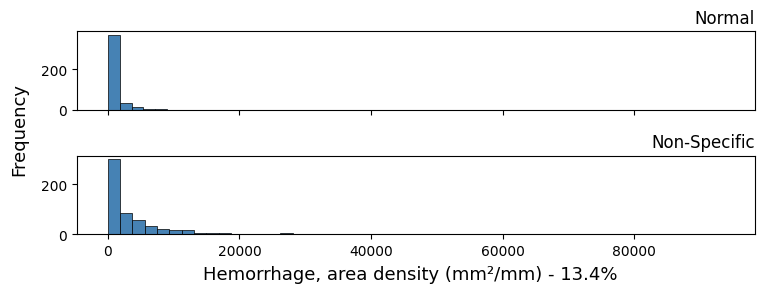

In [67]:
col='hemorrhage_area_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_normal[col], bins=10, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Normal', loc='right')

axs[1].hist(capis_non_specific[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('Non-Specific', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_non_ssc[col]), ha='center',fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical',fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_non_ssc.svg", bbox_inches="tight")
plt.savefig(col + "_non_ssc.png", dpi=300, bbox_inches="tight")

plt.show()

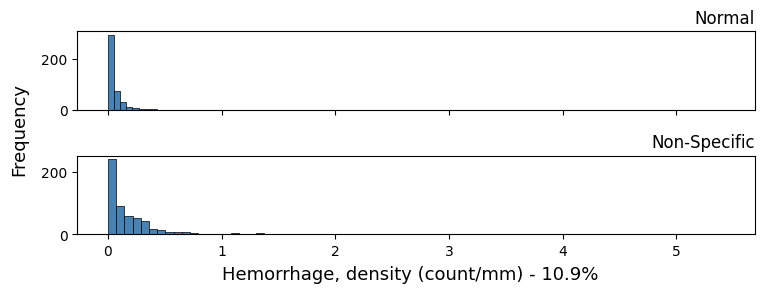

In [68]:
col = 'hemorrhage_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_normal[col], bins=10, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Normal', loc='right')

axs[1].hist(capis_non_specific[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('Non-Specific', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_non_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_non_ssc.svg", bbox_inches="tight")
plt.savefig(col + "_non_ssc.png", dpi=300, bbox_inches="tight")

plt.show()


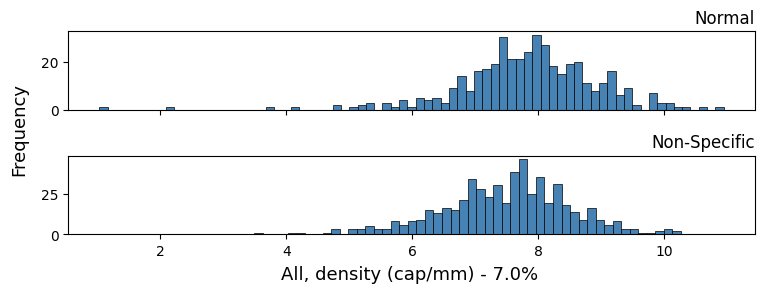

In [69]:
col = 'all_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_normal[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Normal', loc='right')

axs[1].hist(capis_non_specific[col], bins=50, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('Non-Specific', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_non_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_non_ssc.svg", bbox_inches="tight")
plt.savefig(col + "_non_ssc.png", dpi=300, bbox_inches="tight")

plt.show()


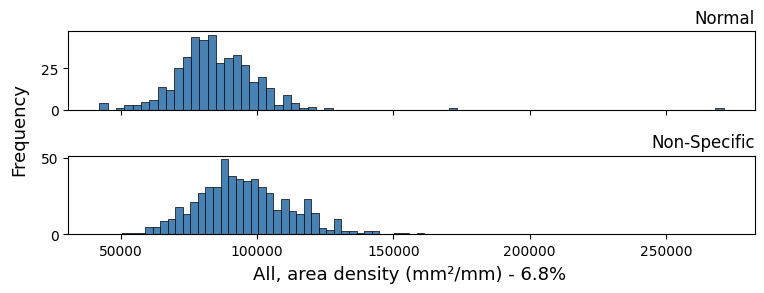

In [70]:
col = 'all_area_density'

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 3))

axs[0].hist(capis_normal[col], bins=75, edgecolor='black', linewidth=0.5, color='steelblue')
axs[0].set_title('Normal', loc='right')

axs[1].hist(capis_non_specific[col], bins=40, edgecolor='black', linewidth=0.5, color='steelblue')
axs[1].set_title('Non-Specific', loc='right')

fig.text(0.5, 0, '{} - {:.1f}%'.format(feature_name_map[col], feature_importances_map_non_ssc[col]), ha='center', fontsize=13)
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=13)

plt.tight_layout(rect=[0.02, 0.02, 0.95, 0.95])

plt.savefig(col + "_non_ssc.svg", bbox_inches="tight")
plt.savefig(col + "_non_ssc.png", dpi=300, bbox_inches="tight")

plt.show()


## Plot feature importances for each model

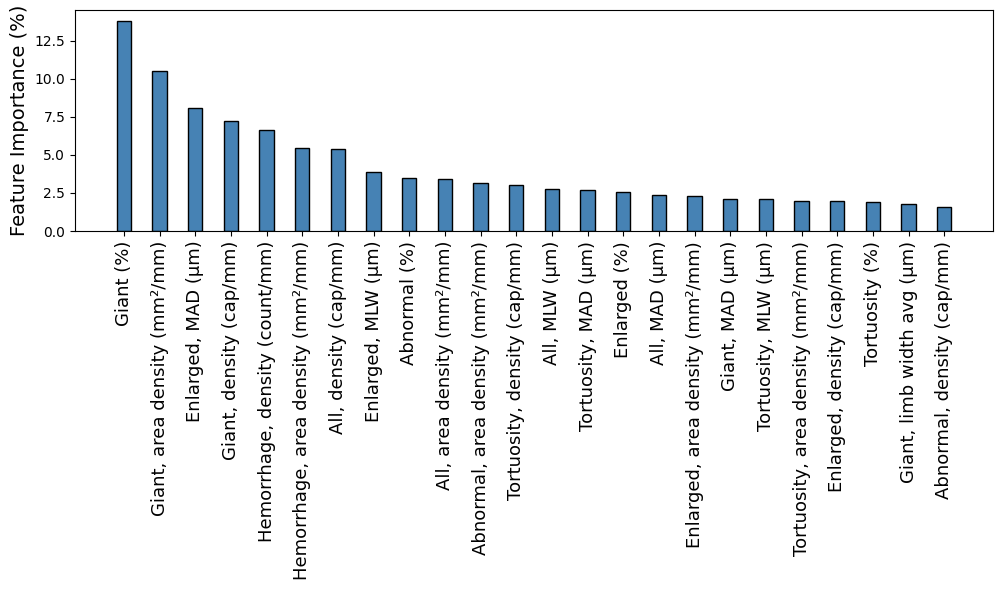

In [71]:
importances = [feature_importances_map[feature] for feature in features]

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names_list[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, width=0.4, color='steelblue', edgecolor='black')
#plt.xlabel('Features', fontsize=12)
plt.ylabel('Feature Importance (%)', fontsize=14)
#plt.title('Feature Importances for SSc vs Non-SSc model', fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('feature_importances_ssc_vs_non_ssc.svg')
plt.savefig('feature_importances_ssc_vs_non_ssc.png', dpi=300)
plt.show()

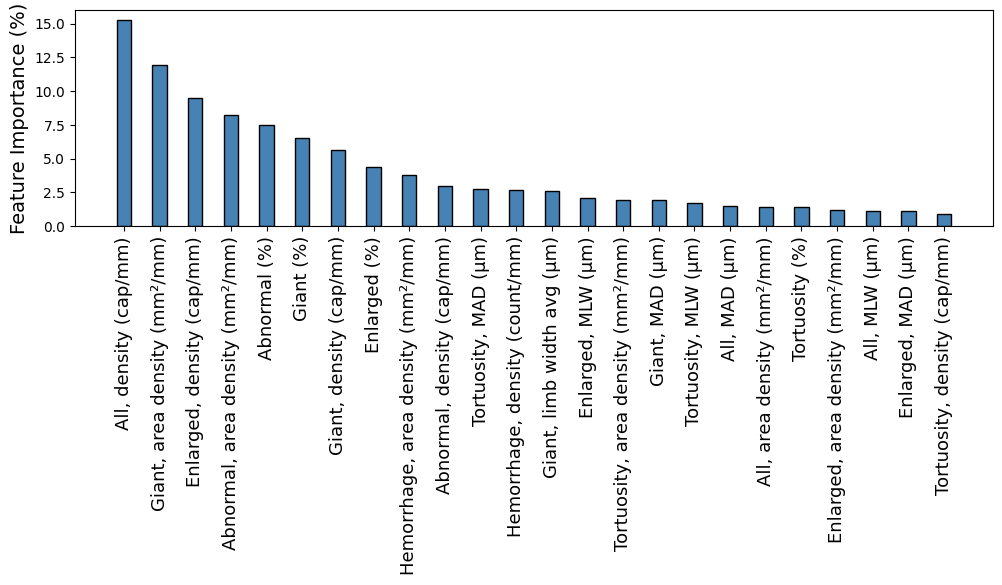

In [72]:
importances = [feature_importances_map_ssc[feature] for feature in features]

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names_list[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, width=0.4, color='steelblue', edgecolor='black')
#plt.xlabel('Features', fontsize=14)
plt.ylabel('Feature Importance (%)', fontsize=14)
#plt.title('Feature Importances for SSc stage model', fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('feature_importances_ssc_stage.svg')
plt.savefig('feature_importances_ssc_stage.png', dpi=300)
plt.show()

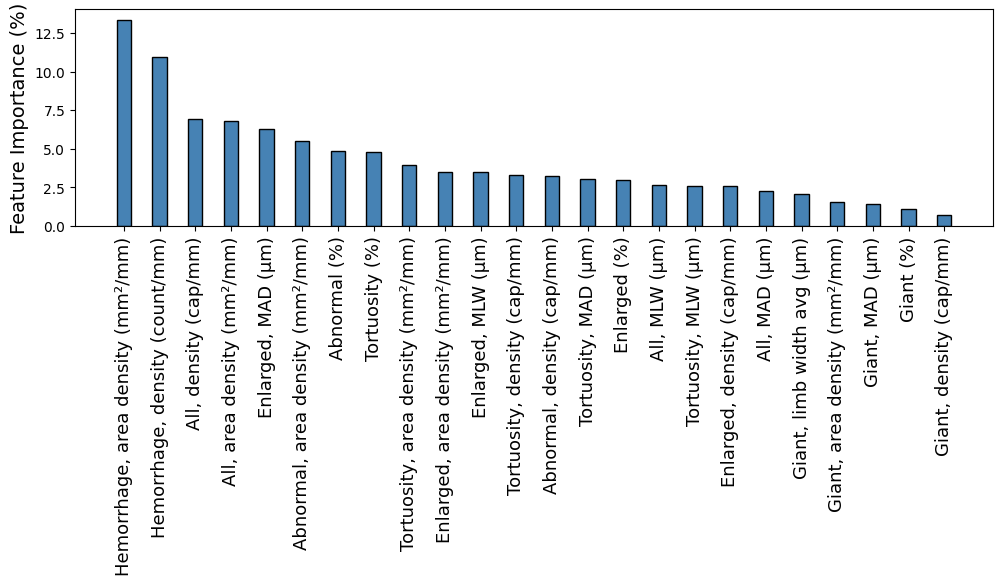

In [73]:
importances = [feature_importances_map_non_ssc[feature] for feature in features]

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names_list[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importances, width=0.4, color='steelblue', edgecolor='black')
#plt.xlabel('Features', fontsize=16)
plt.ylabel('Feature Importance (%)', fontsize=14)
#plt.title('Feature Importances for SSc stage model', fontsize=13)
plt.xticks(rotation=90, fontsize=13)
plt.tight_layout()
plt.savefig('feature_importances_non_ssc_type.svg')
plt.savefig('feature_importances_non_ssc_type.png', dpi=300)
plt.show()